<a href="https://colab.research.google.com/github/nrlopez03/Pooled-Testing/blob/main/Pooled_Testing_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements

In [1]:
import pandas as pd
import numpy as np
import random
import math
import itertools
import ast
import time
from scipy.stats import bernoulli
from itertools import combinations
from itertools import combinations_with_replacement
from itertools import product
from itertools import chain
from collections import defaultdict
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.linear_model import LinearRegression
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import csv
import ast
from mosek.fusion import *
import math
from scipy.optimize import brentq 
from math import log, exp
import gurobipy as gp
from gurobipy import GRB

plt.rcParams['figure.dpi'] = 300

2024-10-15 11:18:21.555284: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 11:18:21.607720: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 11:18:21.608521: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 11:18:22.779555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Model

In [2]:
# define parameters

B = 2
k = 2
N = 3
G = N

In [3]:
# list of (id, utility, probability of healthy) tuples

def create_agents(N = N, uIntegers=False):
  agents = list()

  for i in range(N):
    if uIntegers:
      agents.append((i, round(random.random() * 100) + 1, random.random()))
    else:
      agents.append((i, random.random(), random.random()))
  return agents

agents = create_agents()

print(agents)

[(0, 0.008368857107330818, 0.9156360343050448), (1, 0.2213676771993235, 0.7428039397585884), (2, 0.8159968527413878, 0.5266558505395824)]


In [4]:
# print results of a static solver

def printStatic(strategy, utility):
  print(f"\nStatic Strategy, Utility {utility}:")
  i = 1
  for group in strategy:
    if group:
      print(f"Group {i}: {group}")
      i += 1

In [5]:
# print results of a dynamic solver

def printDynamic(strategy, utility = 0, i = 1, greedy = False):
  if utility > 0:
    if greedy:
      print(f"\nGreedy Dynamic Strategy, Utility {utility}:")
    else:
      print(f"\nDynamic Strategy, Utility {utility}:")
  if len(strategy)>0:
    print(f"Test {i}: {strategy[0]}")
    i+=1
    if len(strategy[1]) > 0:
      print(('\t' * (i - 1)) + f"If positive, ", end="")
      printDynamic(strategy[1], 0, i)
    if len(strategy[2]) > 0:
        # i += 1
        print(('\t' * (i - 1)) + f"If negative, ", end="")
        printDynamic(strategy[2], 0, i)

In [6]:
# print results of a dynamic solver

def printTree(strategy, utility = 0, i = 1, greedy = False):
  if utility > 0:
    if greedy:
      print(f"\nGreedy Dynamic Strategy, Utility {utility}:")
    else:
      print(f"\nDynamic Strategy, Utility {utility}:")
  if strategy:
    print(f"Test {i}: {strategy[0]}")
    if strategy[1]:
      i+=1
      print(('\t' * (i - 1)) + f"If positive, ", end="")
      printTree(strategy[1], 0, i)
    if strategy[2]:
        # i += 1
        print(('\t' * (i - 1)) + f"If negative, ", end="")
        printTree(strategy[2], 0, i)

In [7]:
def generate_binary_tree(strategy):
    # Base case: if the strategy is empty, return None
    if not strategy:
        return None
    
    # Extract the current test and its positive and negative branches
    current_test = set([person[0] for person in strategy[0]])
    positive_branch = generate_binary_tree(strategy[1])
    negative_branch = generate_binary_tree(strategy[2])
    
    # Return a tuple representing the binary tree node
    return (current_test, positive_branch, negative_branch)

In [8]:
def tree_to_boolean_list(tree, N, bool_list=None):

    if bool_list is None:
        bool_list = []

    new_list = [False] * N

    # Unpack the tree node
    values, left, right = tree

    # Update the boolean list for this level
    for val in values:
        new_list[val] = True

    bool_list += new_list

    # Recurse for the left and right subtrees, moving to the next level
    if left:
        bool_list = tree_to_boolean_list(left, N, bool_list)
    if right:
        bool_list = tree_to_boolean_list(right, N, bool_list)

    return bool_list

# Example usage:
tree = ({0, 1}, ({1}, ({1}, None, None), ({1}, None, None)), ({2}, ({1}, None, None), ({1}, None, None)))

boolean_list = tree_to_boolean_list(tree, N)


In [9]:
def boolean_list_to_tree(bool_list, N,):

    # Extract the current node values
    current_values = {i for i in range(N) if bool_list[i]}

    if len(bool_list) == N:
        return (current_values, None, None)
    
    # Move the index forward by N for the next segment
    cutoff = N + ((len(bool_list) - N) // 2)

    leftList = bool_list[N : cutoff]
    rightList = bool_list[cutoff:]

    # Recursively construct the left subtree
    left_subtree = boolean_list_to_tree(leftList, N)

    # Recursively construct the right subtree
    right_subtree = boolean_list_to_tree(rightList, N)

    return (current_values, left_subtree, right_subtree)

# Example usage:
boolean_list = [True, True, False, False, True, False, False, True, False, False, True, False, False, False, True, False, True, False, False, True, False]
N = 3
reconstructed_tree = boolean_list_to_tree(boolean_list, N)


## Algorithms

### Maximum Utility

In [10]:
def maxUtil(agents):
  util = 0
  for agent in agents:
    util += agent[1] * agent[2]
  return util

In [11]:
maxUtil(agents)

0.6018451264104249

### Conic Single Test

In [12]:
"""
MICOP model for a single test that can be solved exactly with MOSEK.
	
Note that the objective value of this model is the log of the overall welfare!
"""
def solveConicSingle(agents, G=G, verbose=False):

    u = [agent[1] for agent in agents]
    q = [agent[2] for agent in agents]

    # Compute population size
    n = len(u)

    assert n == len(q), "Input vectors have different lengths."
    assert all(u[i] >= 0 for i in range(n)), "Utilities must be non-negative."
    assert all(q[i] >= 0 and q[i] <= 1 for i in range(n)), "Probabilities must lie between 0 and 1."

    # Hack alert: Conic program doesn't like -math.inf 
    q = [(math.log(qi) if qi!= 0 else -100000000000) for qi in q]

    with Model('ceo1') as M:
        # Define variables
        x = M.variable("x", n, Domain.binary())
        y = M.variable("y", 1, Domain.unbounded())
        z = M.variable("z", 1, Domain.unbounded())
        d = M.variable("d", 1, Domain.equalsTo(1))
        t = Var.vstack(z.index(0), d.index(0), y.index(0))

        # Add objective
        M.objective("obj", ObjectiveSense.Maximize, Expr.add(y.index(0), Expr.dot(x, q)))

        # Add constraints
        M.constraint("ev", Expr.sub(Expr.dot(u, x), z.index(0)), Domain.equalsTo(0))
        M.constraint("expc", t, Domain.inPExpCone())

        # Pooled testing size constraint

        M.constraint("pool", Expr.sum(x), Domain.lessThan(G))

        M.solve()

        utility = math.exp(M.primalObjValue())
        strategy = tuple(agent for agent, level in zip(agents, np.round_(x.level())) if level == 1)

        return  strategy, utility

In [13]:
agents = [(0, 1, 0.5), (1, 1, 0.5), (2, 1, 0.4)]
singleStrategy, singleUtility = solveConicSingle(agents)
printStatic(singleStrategy, singleUtility)


Static Strategy, Utility 0.530737847752237:
Group 1: (1, 1, 0.5)


In [14]:
agents = [(0, 1, 0.5), (1, 1, 0.5), (2, 1, 0.4)]
singleStrategy, singleUtility = solveConicSingle(agents)
printStatic(singleStrategy, singleUtility)


Static Strategy, Utility 0.530737847752237:
Group 1: (1, 1, 0.5)


### Static Non-Pooled

In [15]:
def solveStaticNoPool(agents, B=B):
  utils = []
  for agent in agents:
    utils.append(agent[1] * agent[2])
  utils = sorted(utils, reverse=True)
    # Take the first B elements and sum them
  util = sum(utils[:B])
  return util

### Static Non-Overlapping

Generate and calculate utility of each partition

In [16]:
def solveStaticNonOverlap(agents, G = G, B = B):

  def generate_non_overlapping_subsets(agents, G, B):
    # Generate all possible subsets of agents with sizes up to G
    subsets = []
    for r in range(1, G+1):
        subsets.extend(combinations(agents, r))

    # Generate combinations of B non-overlapping subsets
    combos = combinations(subsets, B)

    # Filter combinations to keep only non-overlapping ones
    non_overlapping_combinations = []
    for combination in combos:
        combined_set = set()
        is_non_overlapping = True
        for subset in combination:
            if combined_set.intersection(subset):
                is_non_overlapping = False
                break
            combined_set.update(subset)
        if is_non_overlapping:
            non_overlapping_combinations.append(combination)

    return non_overlapping_combinations

  def strategyUtilitySNO(combination):
    utility = 0
    for group in combination:
      groupUtility = 0
      groupHealthy = 1
      for person in group:
        groupUtility += person[1]
        groupHealthy *= person[2]
      utility += groupHealthy * groupUtility
    return utility

  strategy = dict()
  combos = generate_non_overlapping_subsets(agents, G, B)
  for combination in combos:
    strategy[combination] = strategyUtilitySNO(combination)
  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

In [17]:
strategy, utility = solveStaticNonOverlap(agents)
printStatic(strategy, utility)


Static Strategy, Utility 1.0:
Group 1: ((0, 1, 0.5),)
Group 2: ((1, 1, 0.5),)


In [18]:
strategy

(((0, 1, 0.5),), ((1, 1, 0.5),))

### Greedy

In [19]:
def solveGreedy(agents, G=G, B=B):

    pools, welfares = [], []

    for test in range(B):

        currentTest, utility = solveConicSingle(agents, G)
        welfares.append(utility) # record welfare
        pools.append(currentTest) # record pool
        # Remove people in pool from population
        agents = [agent for agent in agents if agent not in currentTest]
        
    strategy = tuple(pools)
    utility = sum(welfares)    

    return strategy, utility

In [20]:
agents

[(0, 1, 0.5), (1, 1, 0.5), (2, 1, 0.4)]

In [ ]:
strategy, utility = solveGreedy(agents, B=3)
printStatic(strategy, utility)


Static Strategy, Utility 1.4307378839367104:
Group 1: ((1, 1, 0.5),)
Group 2: ((0, 1, 0.5),)
Group 3: ((2, 1, 0.4),)


### MILP

In [22]:
def solveMILP(agents, G=G, B=B):

    def approx_model(q, u, n, T=B, G=G, K=20):
        
        """
        Build cluster-based MILP model for Gurobi to solve. Finds an approximately
        optimal testing allocation.
        Inputs are three vectors indexed by cluster, as well as number of tests T
        and pool size bound G, and accuracy parameter K.

        q::Vector - avg. probability of being healthy for each cluster
        u::Vector - utility for each cluster
        n::Vector - size of each cluster
        T::Int 	  - number of tests
        G::Int    - pooled test size
        K::Int 	  - number of segments of piecewise-linear fn approximating exp constraint
        """
        # Verify that input is consistent
        assert len(u) == len(q) == len(n), "Input vectors have different lengths."
        assert K >= 1, "Number of segments for approximating exp must be at least 1."
        assert T <= sum(n), "Number of tests cannot exceed number of people in population."
        assert all(isinstance(x, int) and x > 0 for x in u), "Utilities must be strictly positive integers."
        assert all(0 <= x <= 1 for x in q), "Probabilities must (strictly) lie between 0 and 1."

        # Compute some constants
        C = len(n)  # number of clusters C
        # Lower and upper bounds for z[t] = x[t]⋅u
        L, U = min(u), G*max(u)
        # print(f"L: {L}, U: {U}")
        # Lower and upper bounds for l[t] = log(x[t]⋅u) + sum(x[t,i]*log(q[i])
        A = min(log(x) for x in u) + G*min(log(x) for x in q)
        B = log(G*max(u)) + max(log(x) for x in q)
        # print(f"A: {A}, B: {B}")
        tests = range(0, T)
        clusters = range(0, C)
        segments = range(0,K)

        # Create model and set parameters
        m = gp.Model('Test Allocation')
        m.setParam('OutputFlag', 0)
        # m.setParam("TimeLimit", 600)
        # m.setParam("Presolve", -1)
        m.setParam('MIPGap', 0.01)

        # Define variables
        x = m.addVars(tests, clusters, lb = 0, vtype = GRB.INTEGER, name='x')
        w = m.addVars(tests, lb=0, name='w')
        l = m.addVars(tests, lb=-GRB.INFINITY, name='l')
        y = m.addVars(tests, lb=-GRB.INFINITY, name='y')
        z = m.addVars(tests, lb=-GRB.INFINITY, name='z')
        # variables for log constraint
        zind = m.addVars(tests, range(L,U+1), vtype=GRB.BINARY, name='zind')
        # variables for approximating exp constraint
        lind = m.addVars(tests, segments, vtype=GRB.BINARY, name='lind')
        v = m.addVars(tests, segments, lb=-GRB.INFINITY, name='v')

        # Set objective
        m.setObjective(sum(w[t] for t in tests), GRB.MAXIMIZE)

        # Add constraints
        m.addConstrs(sum(x[t,i] for t in tests) <= n[i] for i in clusters)  # tests must be disjoint
        m.addConstrs(1 <= sum(x[t,i] for i in clusters) for t in tests)  # pool size >= 1
        m.addConstrs(sum(x[t,i] for i in clusters) <= G for t in tests)  # pool size <= G

        # Log welfare constraints: l[t] == log(u ̇x[t]) + x[t] ̇log.(q)
        m.addConstrs(l[t] == y[t] + sum(x[t,i] * log(q[i]) for i in clusters) for t in tests)

        # Constraints to ensure y[t] <= log(z[t])
        m.addConstrs(z[t] == sum(x[t,i] * u[i] for i in clusters) for t in tests)  # utility sums
        # Use indictator variables t capture value of z[t]:
        # z[t] is an integer in [L, U], so let zind[t,k] = 1 if z[t] = k and 0 otherwise.
        m.addConstrs(1==sum(zind[t,k] for k in range(L,U+1)) for t in tests)  # exactly one zind entry is 1
        m.addConstrs(z[t] == sum(k*zind[t,k] for k in range(L,U+1)) for t in tests)
        m.addConstrs(y[t] <= sum(log(k)*zind[t,k] for k in range(L,U+1)) for t in tests)

        # Deal with w[t] = exp(l[t])
        if abs(B-A) < 1e-10:
            m.addConstrs(l[t] == A for t in tests)
            m.addConstrs(w[t] == exp(A) for t in tests)
        else:
            # Approximate w[t] <= exp(l[t]) using piecewise-linear function f with K segments on domain [A,B]
            c = optimal_partition(A, B, K)  # compute optimal segmentation of interval [A, B]
            a, b, c = linearise(exp, c)  # compute piecewise-linear function f on domain [A, B] with segmentation c
            # print(a, b, c)
            # Use indicator variables `lind[t,k]` to capture in which segment the value of l[t] lies
            # and let v[t,k] = l[t] if l[t] lies in (c[k], c[k+1]) and v[t,k] = 0 otherwise.
            m.addConstrs(1 == sum(lind[t,k] for k in segments) for t in tests)
            m.addConstrs(c[k]*lind[t,k] <= v[t,k] for t in tests for k in segments)
            m.addConstrs(v[t,k] <= c[k+1]*lind[t,k] for t in tests for k in segments)
            m.addConstrs(l[t] == sum(v[t,k] for k in segments) for t in tests)
            # Ensure that w[t] <= f(l[t])
            m.addConstrs(w[t] <= sum(a[k]*v[t,k] + b[k]*lind[t,k] for k in segments) for t in tests)

        # Return model
        return m, x
    
    def linearise(f, c):
        """
        Compute the piecewise-linear representation of `f` with segments specified
        in vector `c`.
        """
        K = len(c)-1  # number of segments
        a, b = np.zeros(K), np.zeros(K)
        for k in range(0,K):
            a[k] = (f(c[k+1]) - f(c[k])) / (c[k+1] - c[k])  # determine slope
            b[k] = f(c[k+1]) - a[k]*c[k+1]  # determine residual
        return a, b, c

    def delta(l, r):
        """
        Compute maximum difference between segment (l, exp(l)) to (r, exp(r))
        and exp(x) on the interval [l,r].
        """
        if r <= l: return 0.0
        a = (exp(l) - exp(r)) / (l - r)
        if a == 0: return 0.0  # happens if l and r are sufficiently similar
        b = exp(r) - a*r
        result = a * log(a) + b - a  # maximum difference, derived from first order conditions
        return max(0, result)  # slight hack to avoid numerical inaccuracies

    def partition(A, K, r1):
        """
        Build a partition of K segments starting from A such that the
        first segment is [A, A+r1] and all segments have the same error
        ε identical to the error of the first segment.
        """
        assert r1 >= 0
        assert K > 0
        c = [A]*(K+1)
        if r1 == 0: return c
        eps = delta(A, A + r1)  # error of the first segment [Lo, r1]
        for k in range(0,K):
            l = c[k]
            # To define the bracket for the root finder, we make the reasonable
            # assumption that the interval will be no larger than r1. (This can
            # be proved easily, I believe).
            r = brentq(lambda x : delta(l,x)-eps, l, l+r1+1)  # Finds r such that Δ(l,r) = ε.
            c[k+1] = r
        return c

    def optimal_partition(A, B, K):
        """
        Find the optimal partition of [A, B] into K segments. Proceeds by searching
        for the right size for the first segment: the size `r1` is right when
        `partition(A, K, r1)` ends (approximately) at `B`.
        """
        assert A < B
        first = brentq(lambda x : partition(A, K, x)[-1]-B, 0, B-A+1)
        c = partition(A, K, first)
        c[K] = B  # to clean things up a bit
        return c

    def compute_error(a,b,c):
        """ Compute the maximum difference between the segments of the piecewise-linear function f(x) specified by a, b,
        c and exp(x).

        NB: For segment k, the difference is maximised at x = log(a[k]).
        """
        ε = np.zeros(len(a))
        for k in range(2,len(a)):
            ε[k] = a[k]*np.log(a[k]) + b[k] - a[k]
        return max(ε)

    # u = [agent[1] for agent in agents]
    # q = [agent[2] for agent in agents]
    # n = [1] * len(agents)
    # m, x = approx_model(q, u, n, T=B, G=G)
    # m.optimize()

    # Group agents by (utility, health) and count them
    grouped_agents = defaultdict(lambda: 0)  # Dictionary to store count
    
    for agent in agents:
        key = (agent[1], agent[2])  # (utility, health)
        grouped_agents[key] += 1  # Increment the count of agents in this group

    u = []
    q = []
    n = []

    # Extract the grouped data
    for (utility, health), count in grouped_agents.items():
        u.append(utility)
        q.append(health)
        n.append(count)

    # Initialize an empty list to store the strategy

    strategy = []

    m, x = approx_model(q, u, n, T=B, G=G)
    m.optimize()

    # Loop over each test
    for test in range(B):
        # Collect the agents assigned to this test
        agents_assigned = []
        
        for cluster in range(len(u)):
            if x[test, cluster].X > 0:  # Only include agents assigned to this test
                # Append (u[cluster], q[cluster], n[cluster]) x[test, cluster].X times
                agents_assigned.extend([(cluster, u[cluster], q[cluster])] * int(x[test, cluster].X))

        strategy.append(tuple(agents_assigned))

    # Convert the strategy list to a tuple of tuples
    strategy = tuple(strategy)

    utility = m.objVal

    return strategy, utility

In [23]:
agents = create_agents(5)
agents

[(0, 0.31046197003128384, 0.17549864319956499),
 (1, 0.3108069748660255, 0.639434840685351),
 (2, 0.23306917509156966, 0.5606013104902486),
 (3, 0.48815603655504125, 0.7148240077918754),
 (4, 0.8359836939783799, 0.8629694556810968)]

In [24]:
strategy, utility = solveStaticNonOverlap(agents, B=3)
printStatic(strategy, utility)


Static Strategy, Utility 1.2691148562862198:
Group 1: ((1, 0.3108069748660255, 0.639434840685351),)
Group 2: ((3, 0.48815603655504125, 0.7148240077918754),)
Group 3: ((4, 0.8359836939783799, 0.8629694556810968),)


In [ ]:
strategy, utility = solveGreedy(agents, B=3)
printStatic(strategy, utility)


Static Strategy, Utility 1.146223479851139:
Group 1: ((3, 0.48815603655504125, 0.7148240077918754), (4, 0.8359836939783799, 0.8629694556810968))
Group 2: ((1, 0.3108069748660255, 0.639434840685351),)
Group 3: ((2, 0.23306917509156966, 0.5606013104902486),)


### Determining Updated Priors, Utilities

In [26]:
def bayesTheorem(agents, posGroups, negAgents):

  posGroups = list(posGroups)
  posGroups = sorted(posGroups, key=len)

  for posGroup in posGroups:
    for posGroupCompare in posGroups:
      if posGroup.issubset(posGroupCompare) and posGroup != posGroupCompare:
        posGroups.remove(posGroupCompare)

  newAgents = []

  for agent in agents:
    if agent[0] in set(negAgents):
      newAgents.append((agent[0], 0, 1))
    else:
      newAgents.append(agent)

  agentDict = {}
  for agent in newAgents:
    agentDict[agent[0]] = (agent[1], agent[2])


  def all_combinations(frozen_sets):

    def pick_at_least_one(agents_set):
      # Generate combinations of different sizes from the set
      combinations_list = []
      for r in range(1, len(agents_set) + 1):
          combinations_list.extend(combinations(agents_set, r))
      return combinations_list

    possibilities = [pick_at_least_one(group) for group in frozen_sets]
    product_result = product(*possibilities)

    # Combine the elements of each tuple into a single set
    combos = {frozenset(chain(*comb)) for comb in product_result}

    return combos

  def getProb(groups):
    involvedAgents = frozenset(chain(*groups))

    possiblePos = all_combinations(groups)

    prob = 0
    for possibility in possiblePos:
      currentOutcome = 1
      for id in involvedAgents:
        if id in possibility:
          currentOutcome *= 1 - agentDict[id][1]
        else:
          currentOutcome *= agentDict[id][1]
      prob += currentOutcome

    return prob

  probPos = {}

  probPos[tuple(posGroups)] = getProb(posGroups)
  probPos[()] = 1

  finalAgents = []

  for agent in newAgents:

    # P(agent is Pos | posGroups) = P(posGroups | agent is Pos) * P(agent in Pos) / P(posGroups)
    # = P(pos Groups agent not in) * P(agent is Pos) / P(posGroups)

    if agent[2] == 1 or agent[2] == 0:
      finalAgents.append(agent)
      # agentDict[agent[0]] = (agent[1], agent[2])

    else:

      posNotIn = [posGroup for posGroup in posGroups if agent[0] not in posGroup]

      if tuple(posNotIn) not in probPos:

        probPos[tuple(posNotIn)] = getProb(posNotIn)

      pAgentPos = probPos[tuple(posNotIn)] * (1 - agent[2]) / probPos[tuple(posGroups)]
      health = 1 - pAgentPos

      finalAgents.append((agent[0], agent[1], health))
      # agentDict[agent[0]] = (agent[1], health)

  for agent in finalAgents:
    agentDict[agent[0]] = (agent[1], agent[2])

  return agentDict

In [27]:
def GibbsMCMCWindow(agents, posGroups, negAgents, max_iterations=1000, tolerance=0.05, min_burn_in=50, window_size = 100):
    
    # Initialize agents with binary states (0: healthy, 1: infected), ensuring negAgents are always healthy
    def initialize_agents_binary(agents, negAgents):
        return {agent[0]: 0 if agent[0] in negAgents else np.random.choice([0, 1], p=[agent[2], 1-agent[2]]) for agent in agents}

    # Gibbs-like sampling: Update one agent's state given the rest of the current states
    def update_agent_state(agent, agent_to_groups, health_states, agent_prob, negAgents):
        """Update the state of the agent (0: healthy, 1: infected) based on the group constraints."""
        if agent in negAgents:
            return 0  # If the agent is in negAgents, they must always be healthy
        
        relevant_groups = agent_to_groups[agent]
        must_be_infected = False
        for group in relevant_groups:
            if all(health_states[other] == 0 for other in group if other != agent):
                must_be_infected = True
                break  # Once the agent must be infected, no need to check other groups
        
        if must_be_infected:
            return 1  # The agent must be infected to satisfy the group constraint
        else:
            return bernoulli.rvs(1 - agent_prob)

    # Initialize binary health states
    health_states = initialize_agents_binary(agents, negAgents)
    
    # Precompute agent-to-groups mapping
    agent_to_groups = {agent[0]: [group for group in posGroups if agent[0] in group] for agent in agents}
    
    # Store history of probabilities to monitor convergence
    health_history = {agent[0]: [] for agent in agents}
    
    # Store counts of healthy samples for each agent
    healthy_counts = {agent[0]: 0 for agent in agents}
    
    # Run MCMC iterations
    for iteration in range(max_iterations):
        for agent in agents:
            # Update the state of each agent given the current states, except for agents in negAgents
            health_states[agent[0]] = update_agent_state(agent[0], agent_to_groups, health_states, agent[2], negAgents)
        
        # Record the number of times each agent is healthy after burn-in
        for agent in agents:
            health_history[agent[0]].append(health_states[agent[0]])
            if len(health_history[agent[0]]) > window_size:
                health_history[agent[0]].pop(0)
        
        # Check for convergence by comparing moving averages
        if iteration > min_burn_in:
            converged = True
            for agent in agents:
                if len(health_history[agent[0]]) >= window_size:
                    avg_health = np.mean(health_history[agent[0]])
                    prev_avg_health = np.mean(health_history[agent[0]][-window_size//2:])
                    if abs(avg_health - prev_avg_health) > tolerance:
                        converged = False
                        break
            if converged:
                burn_in = iteration
                break
    else:
        burn_in = max_iterations  # No convergence detected, use max iterations
    
    # After burn-in, recalculate final health probabilities
    for iteration in range(burn_in, max_iterations):
        for agent in agents:
            health_states[agent[0]] = update_agent_state(agent[0], agent_to_groups, health_states, agent[2], negAgents)
        
        for agent in agents:
            if health_states[agent[0]] == 0:
                healthy_counts[agent[0]] += 1
    
    # Calculate the final probabilities of being healthy
    total_samples = max_iterations - burn_in
    final_probs = {agent[0]: healthy_counts[agent[0]] / total_samples for agent in agents}
    
    # Prepare the agentDict to return, setting utility to 0 for negAgents
    agentDict = {}
    for agent in agents:
        agent_id = agent[0]
        if agent_id in negAgents:
            agentDict[agent_id] = (0, 1)  # Utility is 0, always healthy
        else:
            agentDict[agent_id] = (agent[1], final_probs[agent_id])  # Utility remains the same, update health probability

    return agentDict

In [28]:
def GibbsMCMC(agents, posGroups, negAgents, iterations=1000, burn_in=250):

    # Initialize agents with binary states (0: healthy, 1: infected), ensuring negAgents are always healthy
    def initialize_agents_binary(agents, negAgents):
        return {agent[0]: 0 if agent[0] in negAgents else np.random.choice([0, 1], p=[agent[2], 1-agent[2]]) for agent in agents}

    # Gibbs-like sampling: Update one agent's state given the rest of the current states
    def update_agent_state(agent, agent_to_groups, health_states, agent_prob, negAgents):
        """Update the state of the agent (0: healthy, 1: infected) based on the group constraints."""
        if agent in negAgents:
            return 0  # If the agent is in negAgents, they must always be healthy
        
        relevant_groups = agent_to_groups[agent]

        # Compute the probability that the agent should be infected based on their group constraints
        must_be_infected = False
        for group in relevant_groups:
            if all(health_states[other] == 0 for other in group if other != agent):
                must_be_infected = True
                break  # Once the agent must be infected, no need to check other groups
        
        if must_be_infected:
            return 1  # The agent must be infected to satisfy the group constraint
        else:
            # Otherwise, use their probability of being healthy (agent_prob)
            return bernoulli.rvs(1 - agent_prob)

    """Perform MCMC to update health states (binary: 0 or 1) and calculate probabilities."""
    # Initialize binary health states (0: healthy, 1: infected), ensuring negAgents are always healthy
    health_states = initialize_agents_binary(agents, negAgents)
    
    # Precompute agent-to-groups mapping to avoid recalculating during iterations
    agent_to_groups = {agent[0]: [group for group in posGroups if agent[0] in group] for agent in agents}
    
    # Store counts of healthy samples for each agent
    healthy_counts = {agent[0]: 0 for agent in agents}
    
    # Run MCMC iterations
    for iteration in range(iterations):
        for agent in agents:
            # Update the state of each agent given the current states, except for agents in negAgents
            health_states[agent[0]] = update_agent_state(agent[0], agent_to_groups, health_states, agent[2], negAgents)
        
        # After burn-in, record the number of times each agent is healthy
        if iteration >= burn_in:
            for agent in agents:
                if health_states[agent[0]] == 0:
                    healthy_counts[agent[0]] += 1
    
    # Calculate the final probabilities of being healthy
    total_samples = iterations - burn_in
    final_probs = {agent[0]: healthy_counts[agent[0]] / total_samples for agent in agents}

    # Prepare the agentDict to return, setting utility to 0 for negAgents
    agentDict = {}
    for agent in agents:
        agent_id = agent[0]
        if agent_id in negAgents:
            agentDict[agent_id] = (0, 1)  # Utility is 0, always healthy
        else:
            agentDict[agent_id] = (agent[1], final_probs[agent_id])  # Utility remains the same, update health probability

    return agentDict

#### Tests with Implementation

Printing Results

In [29]:
def printBayes(agentDict):

  print("Agent, P(Infected), Utility of Testing Negative")

  for ID in agentDict:
    print(f"Agent {ID}: {1 - agentDict[ID][1]}, {agentDict[ID][0]}")

Custom Testing

In [30]:
agents = [(0, 1, 1/2), (1, 1, 1/2), (2, 1, 1/2)]
posGroups = [frozenset({0,1}), frozenset({1,2})]
negAgents = {}
printBayes(bayesTheorem(agents, posGroups, negAgents))
print("\n")
printBayes(GibbsMCMC(agents, posGroups, negAgents))

Agent, P(Infected), Utility of Testing Negative
Agent 0: 0.6, 1
Agent 1: 0.8, 1
Agent 2: 0.6, 1


Agent, P(Infected), Utility of Testing Negative
Agent 0: 0.5840000000000001, 1
Agent 1: 0.8453333333333333, 1
Agent 2: 0.5653333333333334, 1


Testing Overlap Results

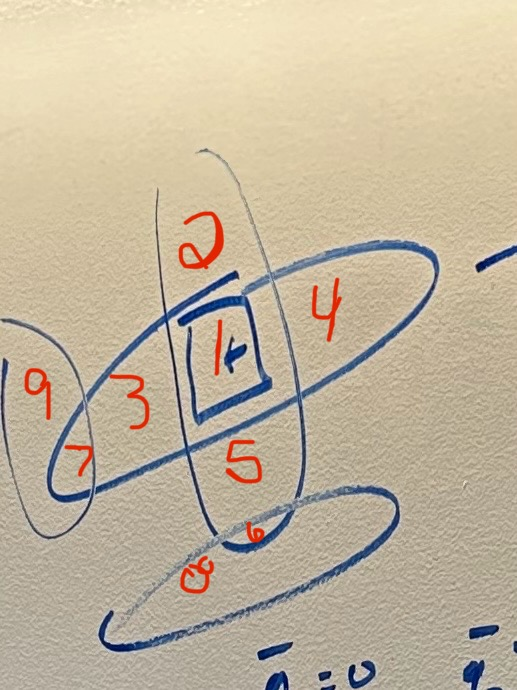

In [31]:
agents = [(i + 1, 1/2, 1/2) for i in range(9)]
posGroups = [frozenset({7, 3, 1, 4}), frozenset({2, 1, 5, 6})]
negAgents = {}
printBayes(bayesTheorem(agents, posGroups, negAgents))
print("\n")
printBayes(GibbsMCMC(agents, posGroups, negAgents))

Agent, P(Infected), Utility of Testing Negative
Agent 1: 0.5663716814159292, 0.5
Agent 2: 0.5309734513274337, 0.5
Agent 3: 0.5309734513274337, 0.5
Agent 4: 0.5309734513274337, 0.5
Agent 5: 0.5309734513274337, 0.5
Agent 6: 0.5309734513274337, 0.5
Agent 7: 0.5309734513274337, 0.5
Agent 8: 0.5, 0.5
Agent 9: 0.5, 0.5


Agent, P(Infected), Utility of Testing Negative
Agent 1: 0.5306666666666666, 0.5
Agent 2: 0.5226666666666666, 0.5
Agent 3: 0.5253333333333333, 0.5
Agent 4: 0.5146666666666666, 0.5
Agent 5: 0.56, 0.5
Agent 6: 0.5706666666666667, 0.5
Agent 7: 0.556, 0.5
Agent 8: 0.5346666666666666, 0.5
Agent 9: 0.4773333333333334, 0.5


In [32]:
agents = [(i + 1, 1/2, 1/2) for i in range(9)]
posGroups = [frozenset({7, 3, 1, 4}), frozenset({2, 1, 5, 6}), frozenset({1})]
negAgents = {}
printBayes(bayesTheorem(agents, posGroups, negAgents))
print("\n")
printBayes(GibbsMCMC(agents, posGroups, negAgents))

Agent, P(Infected), Utility of Testing Negative
Agent 1: 1.0, 0.5
Agent 2: 0.5, 0.5
Agent 3: 0.5, 0.5
Agent 4: 0.5, 0.5
Agent 5: 0.5, 0.5
Agent 6: 0.5, 0.5
Agent 7: 0.5, 0.5
Agent 8: 0.5, 0.5
Agent 9: 0.5, 0.5


Agent, P(Infected), Utility of Testing Negative
Agent 1: 1.0, 0.5
Agent 2: 0.48, 0.5
Agent 3: 0.4733333333333334, 0.5
Agent 4: 0.5213333333333333, 0.5
Agent 5: 0.512, 0.5
Agent 6: 0.5186666666666666, 0.5
Agent 7: 0.4933333333333333, 0.5
Agent 8: 0.516, 0.5
Agent 9: 0.5013333333333334, 0.5


In [33]:
agents = [(i + 1, 1/2, 1/2) for i in range(9)]
posGroups = [frozenset({7, 3, 1, 4}), frozenset({2, 1, 5, 6}), frozenset({1}), frozenset({8, 6}), frozenset({9, 7})]
negAgents = {}
printBayes(bayesTheorem(agents, posGroups, negAgents))
print("\n")
printBayes(GibbsMCMC(agents, posGroups, negAgents))

Agent, P(Infected), Utility of Testing Negative
Agent 1: 1.0, 0.5
Agent 2: 0.5, 0.5
Agent 3: 0.5, 0.5
Agent 4: 0.5, 0.5
Agent 5: 0.5, 0.5
Agent 6: 0.6666666666666666, 0.5
Agent 7: 0.6666666666666666, 0.5
Agent 8: 0.6666666666666666, 0.5
Agent 9: 0.6666666666666666, 0.5


Agent, P(Infected), Utility of Testing Negative
Agent 1: 1.0, 0.5
Agent 2: 0.492, 0.5
Agent 3: 0.516, 0.5
Agent 4: 0.4973333333333333, 0.5
Agent 5: 0.4813333333333333, 0.5
Agent 6: 0.6719999999999999, 0.5
Agent 7: 0.6746666666666667, 0.5
Agent 8: 0.6693333333333333, 0.5
Agent 9: 0.6733333333333333, 0.5


In [34]:
agents = [(i + 1, 1/2, 1/2) for i in range(9)]
posGroups = [frozenset({1}), frozenset({8, 6}), frozenset({9, 7})]
negAgents = {}
printBayes(bayesTheorem(agents, posGroups, negAgents))
print("\n")
printBayes(GibbsMCMC(agents, posGroups, negAgents))

Agent, P(Infected), Utility of Testing Negative
Agent 1: 1.0, 0.5
Agent 2: 0.5, 0.5
Agent 3: 0.5, 0.5
Agent 4: 0.5, 0.5
Agent 5: 0.5, 0.5
Agent 6: 0.6666666666666666, 0.5
Agent 7: 0.6666666666666666, 0.5
Agent 8: 0.6666666666666666, 0.5
Agent 9: 0.6666666666666666, 0.5


Agent, P(Infected), Utility of Testing Negative
Agent 1: 1.0, 0.5
Agent 2: 0.45866666666666667, 0.5
Agent 3: 0.528, 0.5
Agent 4: 0.4986666666666667, 0.5
Agent 5: 0.5013333333333334, 0.5
Agent 6: 0.6906666666666667, 0.5
Agent 7: 0.6933333333333334, 0.5
Agent 8: 0.6586666666666667, 0.5
Agent 9: 0.6546666666666667, 0.5


### Static Overlapping

In [35]:
def solveStaticOverlap(agents, G = G, B = B):

  def generate_overlapping_subsets(agents, G, B):

    # Generate all possible subsets of agents with sizes up to G
    subsets = []
    for r in range(1, G+1):
        subsets.extend(combinations(agents, r))

    # Generate combinations of B subsets without enforcing overlap
    combos = combinations(subsets, B)
    return combos

  def groupHelp(group, posGroups = frozenset(), negAgents = frozenset()):

    groupIDs = frozenset({person[0] for person in group})
    groupUtility = 0
    groupHealthy = 1
    for posGroup in posGroups:
      if posGroup.issubset(groupIDs):
        groupHealthy = 0

    agentDict = bayesTheorem(agents, posGroups, negAgents)

    for person in group:
      groupUtility += agentDict[person[0]][0]
      groupHealthy *= agentDict[person[0]][1]

    groupUtility *= groupHealthy
    return groupHealthy, groupUtility


  def strategyUtility(combination, posGroups = frozenset(), negAgents = frozenset()):

    utility = 0

    if len(combination) > 0:

      firstGroup = combination[0]
      groupIDs = frozenset({person[0] for person in firstGroup})

      firstHealthy, firstUtility = groupHelp(firstGroup, posGroups, negAgents)
      utility += firstUtility

      # positive test
      if firstHealthy < 1:
        posScenario = combination[1:]

        newPosGroups = set(posGroups.copy())

        for posGroup in newPosGroups:
          if groupIDs.issubset(posGroup):
            newPosGroups.remove(posGroup)

        newPosGroups.add(groupIDs.difference(negAgents))

        utility += strategyUtility(posScenario, frozenset(newPosGroups), frozenset(negAgents)) * (1-firstHealthy)

      # negative test
      if firstHealthy > 0:

        negScenario = combination[1:]

        newPosGroups = set()
        for posGroup in posGroups:
          newPosGroups.add(posGroup.difference(groupIDs))

        newNegAgents = set(negAgents.copy())
        newNegAgents.update(groupIDs)

        utility += strategyUtility(negScenario, frozenset(newPosGroups), frozenset(newNegAgents)) * firstHealthy

    return utility

  strategy = dict()
  combos = generate_overlapping_subsets(agents, G, B)
  for combination in combos:
    strategy[combination] = strategyUtility(combination)
  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

In [36]:
agents = [(0, 1, 0.5), (1, 1, 0.5), (2, 1, 1)]
staticStrategy, staticUtility = solveStaticOverlap(agents)
printStatic(staticStrategy, staticUtility)


Static Strategy, Utility 1.75:
Group 1: ((0, 1, 0.5), (2, 1, 1))
Group 2: ((1, 1, 0.5), (2, 1, 1))


In [37]:
print(staticStrategy)

(((0, 1, 0.5), (2, 1, 1)), ((1, 1, 0.5), (2, 1, 1)))


In [38]:
agents = [(0, 0.022080006061812485, 0.8205655186482051), (1, 0.760970132052074, 0.5930101907614745), (2, 0.42354957403482274, 0.6984521403961065), (3, 0.006600413727435472, 0.2859953353854493), (4, 0.616360236705176, 0.29752798376295153)]
staticStrategy, staticUtility = solveStaticOverlap(agents, B= 4)
printStatic(staticStrategy, staticUtility)


Static Strategy, Utility 0.9485946598448791:
Group 1: ((0, 0.022080006061812485, 0.8205655186482051),)
Group 2: ((1, 0.760970132052074, 0.5930101907614745),)
Group 3: ((2, 0.42354957403482274, 0.6984521403961065),)
Group 4: ((4, 0.616360236705176, 0.29752798376295153),)


### Dynamic

In [39]:
def solveDynamic(agents, G = G, B = B, posGroups = frozenset(), negAgents = frozenset()):

  if B == 0:
    return [], 0

  def generate_subsets(agents, G=G):
      subsets = []
      for r in range(1, G + 1):
          subsets.extend(combinations(agents, r))
      return subsets

  strategy = dict()
  combos = generate_subsets(agents, G)
  for combination in combos:
    utility = 0

    # first test
    firstTest = combination
    firstUtility = 0
    firstHealthy = 1

    # remaining agents
    remaining = [person for person in agents if person not in firstTest]

    # utility, P(Healthy) of first test
    firstIDs = frozenset({person[0] for person in firstTest})
    if posGroups:
      for posGroup in posGroups:
        if posGroup.issubset(firstIDs):
          firstHealthy = 0
    else:
      posGroups = frozenset()

    agentDict = bayesTheorem(agents, posGroups, negAgents)

    for person in firstTest:
      firstUtility += agentDict[person[0]][0]
      firstHealthy *= agentDict[person[0]][1]
    utility += firstUtility * firstHealthy

    # positive scenario
    if firstHealthy < 1:

      newPosGroups = set(posGroups.copy())
      newPosGroups.add(firstIDs.difference(negAgents))

      posStrategy, posUtility = solveDynamic(agents, G, B-1, frozenset(newPosGroups), frozenset(negAgents))

      utility += (1- firstHealthy) * posUtility

    else:

      posStrategy = []

    # negative scenario

    if remaining and firstHealthy > 0:
      newPosGroups = set()
      for posGroup in posGroups:
        newPosGroups.add(posGroup.difference(firstIDs))

      newNegAgents = set(negAgents.copy())
      newNegAgents.update(firstIDs)


      negStrategy, negUtility = solveDynamic(remaining, G, B-1, frozenset(newPosGroups), frozenset(newNegAgents))
      utility += firstHealthy * negUtility

    else:

      negStrategy = []

    strategy[(tuple(firstTest), tuple(posStrategy), tuple(negStrategy))] = utility

  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

In [40]:
agents = [(0, 1, 0.5), (1, 1, 0.5), (2, 1, 1)]
dynamicStrategy, dynamicUtility = solveDynamic(agents)

printDynamic(dynamicStrategy, dynamicUtility)


Dynamic Strategy, Utility 1.75:
Test 1: ((0, 1, 0.5), (2, 1, 1))
	If positive, Test 2: ((2, 1, 1),)
	If negative, Test 2: ((1, 1, 0.5),)


#### Neural Network

In [41]:
agents = [(0, 0.129, 0.5562), (1, 0.17483, 1), (2, 0.569, 0.12)]

dynamicStrategy, dynamicUtility = solveDynamic(agents)

printDynamic(dynamicStrategy, dynamicUtility)

print(generate_binary_tree(dynamicStrategy))

print(tree_to_boolean_list(generate_binary_tree(dynamicStrategy), N))

print(boolean_list_to_tree(tree_to_boolean_list(generate_binary_tree(dynamicStrategy), N), N))


Dynamic Strategy, Utility 0.28455713600000004:
Test 1: ((0, 0.129, 0.5562), (1, 0.17483, 1))
	If positive, Test 2: ((1, 0.17483, 1),)
	If negative, Test 2: ((2, 0.569, 0.12),)
({0, 1}, ({1}, None, None), ({2}, None, None))
[True, True, False, False, True, False, False, False, True]
({0, 1}, ({1}, None, None), ({2}, None, None))


In [42]:
def analyzeTree(tree, agents, posGroups = frozenset(), negAgents = frozenset()):

  utility = 0

  # first test
  firstTest, posStrategy, negStrategy = tree
  firstUtility = 0
  firstHealthy = 1

  # remaining agents
  remaining = [person for person in agents if person not in firstTest]

  # utility, P(Healthy) of first test
  firstIDs = frozenset(firstTest)
  if posGroups:
    for posGroup in posGroups:
      if posGroup.issubset(firstIDs):
        firstHealthy = 0
  else:
    posGroups = frozenset()

  agentDict = bayesTheorem(agents, posGroups, negAgents)

  for person in firstTest:
    firstUtility += agentDict[person][0]
    firstHealthy *= agentDict[person][1]
  utility += firstUtility * firstHealthy

  # positive scenario
  if firstHealthy < 1:

    newPosGroups = set(posGroups.copy())
    newPosGroups.add(firstIDs.difference(negAgents))

    posUtility = analyzeTree(posStrategy, agents, frozenset(newPosGroups), frozenset(negAgents)) if posStrategy else 0
    
    utility += (1- firstHealthy) * posUtility

  else:

    posStrategy = []

  # negative scenario

  if remaining and firstHealthy > 0:
    newPosGroups = set()
    for posGroup in posGroups:
      newPosGroups.add(posGroup.difference(firstIDs))

    newNegAgents = set(negAgents.copy())
    newNegAgents.update(firstIDs)


    negUtility = analyzeTree(negStrategy, agents, frozenset(newPosGroups), frozenset(newNegAgents)) if negStrategy else 0
    utility += firstHealthy * negUtility

  else:

    negStrategy = []

  return utility

In [43]:
def create_training_data(num_samples, G, B, N):
    # Define file path
    file_path = f'data/training/training_data_N{N}_B{B}_G{G}.csv'

    # Check if file exists
    if os.path.exists(file_path):
        # Load existing data
        existing_data = pd.read_csv(file_path)
        current_samples = len(existing_data)
        print(f"Found {current_samples} existing samples.")
    else:
        # No existing data
        existing_data = pd.DataFrame(columns=['agents', 'optimalStrategy', 'utility'])
        current_samples = 0

    # Calculate how many new samples are needed
    samples_needed = num_samples - current_samples

    X = []
    y = []
    
    if samples_needed > 0:
        # Create only the needed samples
        print(f"Generating {samples_needed} new samples...")
        for iter in tqdm(range(samples_needed)):
            agents = create_agents(N)  # Replace with your agent creation function
            input_features = np.array([agent[1:] for agent in agents]).flatten()  # Flattened utility and health
            optimal_strategy, utility = solveDynamic(agents, G, B)  # Replace with your dynamic solution
            output_array = tree_to_boolean_list(generate_binary_tree(optimal_strategy), N)  # Convert strategy to boolean array

            # Append to the lists
            X.append(input_features)
            y.append(output_array)

            # Append new data to the DataFrame
            new_row = {'agents': str(agents), 'optimalStrategy': str(output_array), 'utility': utility}
            existing_data = pd.concat([existing_data, pd.DataFrame([new_row])], ignore_index=True)

            # Save updated data to CSV
            if iter % 100 == 0 or iter + 1 == samples_needed: 
                existing_data.to_csv(file_path, index=False)
                # print(f"Saved new training data to {file_path}.")
    else:
        print("No new samples needed.")

    # Prepare the final X and y for return (load all available data)
    X = np.array([np.array([agent[1:] for agent in ast.literal_eval(row['agents'])]).flatten() 
                  for _, row in existing_data.iterrows()])
    y = np.array([ast.literal_eval(row['optimalStrategy']) for _, row in existing_data.iterrows()])

    return X, y

In [44]:
# Neural Network Class
class GroupTestingNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(GroupTestingNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.output(x))  # Sigmoid activation for binary outputs

# Function to load the model
def load_model(model, epochs, directory='models'):
    filename = os.path.join(directory, f'group_testing_nn_epochs_{epochs}_G{G}_N{N}_B{B}.pth')
    if os.path.exists(filename):
        model.load_state_dict(torch.load(filename))
        return True
    return False

# Training and Evaluation
def train_model(num_samples, B, total_epochs, G, N, existing_epochs=0):

    # Function to save the model
    def save_model(model, epochs, directory='models'):
        if not os.path.exists(directory):
            os.makedirs(directory)
        torch.save(model.state_dict(), os.path.join(directory, f'group_testing_nn_epochs_{epochs}_G{G}_N{N}_B{B}.pth'))

    # Initialize model, loss function, and optimizer
    input_size = N * 2  # N agents, 2 features each (utility and health)
    output_size = (2 ** (B) - 1) * N  # Output size based on requirements
    model = GroupTestingNN(input_size, output_size)

    # Load existing model if it has been trained enough
    if load_model(model, existing_epochs):
        print(f'Loaded model trained for {existing_epochs} epochs.')
    else:
        print('No existing model found. Training from scratch.')
    
    # Calculate the remaining epochs needed
    remaining_epochs = total_epochs - existing_epochs
    
    if remaining_epochs > 0:
        print(f'Training model for {remaining_epochs} more epochs.')

        # Create training data
        X, y = create_training_data(num_samples, G, B, N)

        # Convert to tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)

        criterion = nn.BCELoss()  # Binary Cross Entropy Loss
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Training loop
        for epoch in tqdm(range(existing_epochs, total_epochs)):
            model.train()
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(X_tensor)  # Forward pass
            loss = criterion(outputs, y_tensor)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            if epoch % 10 == 0:
                print(f'Epoch [{epoch}/{total_epochs}], Loss: {loss.item():.4f}')

        # Save the model after training
        save_model(model, total_epochs)
    else:
        print(f'Training complete. Model has already been trained for {total_epochs} epochs.')

    return model

# Evaluation function
def evaluate_model(model, agents):
    model.eval()
    input_features = np.array([agent[1:] for agent in agents]).flatten()
    input_tensor = torch.tensor(input_features, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(input_tensor).numpy().flatten()
    predicted_strategy = (output > 0.5).astype(bool)
    return predicted_strategy

B = 2  
N = 3
G = N

10,000 samples and 1,000 epochs

B = 3  
N = 5
G = N

10,000 samples and 1,000 epochs

In [45]:
num_samples = 10000  # Number of training samples
N = 5
B = 3  
G = N
total_epochs = 1000  # Total number of epochs to train
existing_epochs = 1000 # Set this to the number of epochs the existing model has been trained

model = train_model(num_samples, B, total_epochs, G, N, existing_epochs)

Loaded model trained for 1000 epochs.
Training complete. Model has already been trained for 1000 epochs.


In [46]:
def solveNN(agents, B, G):
    predicted_output = evaluate_model(model, agents)
    predUtility = analyzeTree(boolean_list_to_tree(predicted_output, N), agents)
    return predUtility

In [47]:
# Evaluate on a new instance
test_agents = create_agents(N)  # Replace with your agent creation function
predicted_output = evaluate_model(model, test_agents)

dynamicStrategy, dynamicUtility = solveDynamic(test_agents, G=G, B=B)

printDynamic(dynamicStrategy, dynamicUtility)

predUtility = analyzeTree(boolean_list_to_tree(predicted_output, N), test_agents)

print(f"\nPredicted Strateg, Utility {predUtility}:")
printTree(boolean_list_to_tree(predicted_output, N))

print(f"\nRatio: {dynamicUtility / predUtility}")


Dynamic Strategy, Utility 0.8824357301664874:
Test 1: ((3, 0.2492667765084342, 0.5246960777318871), (4, 0.07134299591772741, 0.9213893129038688))
	If positive, Test 2: ((2, 0.73623894274959, 0.2455776362093074),)
		If positive, Test 3: ((1, 0.6831014042139554, 0.8002228054665058),)
		If negative, Test 3: ((1, 0.6831014042139554, 0.8002228054665058),)
	If negative, Test 2: ((2, 0.73623894274959, 0.2455776362093074),)
		If positive, Test 3: ((1, 0.6831014042139554, 0.8002228054665058),)
		If negative, Test 3: ((1, 0.6831014042139554, 0.8002228054665058),)

Predicted Strateg, Utility 0.6526976266727288:
Test 1: {1, 4}
	If positive, Test 2: {1, 4}
		If positive, Test 3: set()
		If negative, Test 3: {2}
	If negative, Test 2: set()
		If positive, Test 3: {3}
		If negative, Test 3: {3}

Ratio: 1.351982440421761


### Greedy Dynamic

In [48]:
# test limits per person
d = round(B / 2)

In [49]:
def solveGreedyDynamic(agents, G = G, B = B, d = d, posGroups = frozenset(), negAgents = frozenset(), testCount = dict()):

  if B == 0:
    return [], 0

  def generate_subsets(agents, G=G):
      subsets = []
      for r in range(1, G + 1):
          subsets.extend(combinations(agents, r))
      return subsets

  strategy = dict()
  availAgents = [agent for agent in agents if (not testCount.get(agent[0]) or testCount.get(agent[0]) < d)]
  if len(availAgents) == 0:
    return [], 0

  combos = generate_subsets(availAgents, G)
  for combination in combos:

    utility = 0

    # first test
    firstTest = combination
    firstUtility = 0
    firstHealthy = 1

    # update counts
    newCount = testCount.copy()
    for person in firstTest:
      if not newCount.get(person[0]):
        newCount[person[0]] = 1
      else:
        newCount[person[0]] += 1

    # remaining agents
    remaining = [person for person in agents if person not in firstTest]

    # utility, P(Healthy) of first test
    firstIDs = frozenset({person[0] for person in firstTest})
    if posGroups:
      for posGroup in posGroups:
        if posGroup.issubset(firstIDs):
          firstHealthy = 0
    else:
      posGroups = frozenset()

    agentDict = bayesTheorem(agents, posGroups, negAgents)

    for person in firstTest:
      firstUtility += agentDict[person[0]][0]
      firstHealthy *= agentDict[person[0]][1]
    utility += firstUtility * firstHealthy

    # positive scenario
    if firstHealthy < 1:

      newPosGroups = set(posGroups.copy())
      newPosGroups.add(firstIDs.difference(negAgents))

      posStrategy, posUtility = solveGreedyDynamic(agents, G, B-1, d, frozenset(newPosGroups), frozenset(negAgents), newCount)

      utility += (1- firstHealthy) * posUtility

    else:

      posStrategy = []

    # negative scenario

    if remaining and firstHealthy > 0:
      newPosGroups = set()
      for posGroup in posGroups:
        newPosGroups.add(posGroup.difference(firstIDs))

      newNegAgents = set(negAgents.copy())
      newNegAgents.update(firstIDs)


      negStrategy, negUtility = solveGreedyDynamic(remaining, G, B-1, d, frozenset(newPosGroups), frozenset(newNegAgents), newCount)
      utility += firstHealthy * negUtility

    else:

      negStrategy = []

    strategy[(tuple(firstTest), tuple(posStrategy), tuple(negStrategy))] = utility

  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

In [50]:
agents = [(0, 0.129, 0.5562), (1, 0.17483, 1), (2, 0.569, 0.12)]
dynamicStrategy, dynamicUtility = solveDynamic(agents, B=2)
greedyDynamicStrategy, greedyDynamicUtility = solveGreedyDynamic(agents, d=1, B=2)

printDynamic(dynamicStrategy, dynamicUtility)
printDynamic(greedyDynamicStrategy, greedyDynamicUtility, greedy=True)


Dynamic Strategy, Utility 0.28455713600000004:
Test 1: ((0, 0.129, 0.5562), (1, 0.17483, 1))
	If positive, Test 2: ((1, 0.17483, 1),)
	If negative, Test 2: ((2, 0.569, 0.12),)

Greedy Dynamic Strategy, Utility 0.24657980000000002:
Test 1: ((0, 0.129, 0.5562),)
	If positive, Test 2: ((1, 0.17483, 1),)
	If negative, Test 2: ((1, 0.17483, 1),)


### Conic and Gibbs Greedy Dynamic

In [51]:
### adapted from https://github.com/edwinlock/csef/tree/main/optimisation/python

def solveConicGibbsGreedyDynamic(agents, G = G, B = B, posGroups = frozenset(), negAgents = frozenset()):

  if B == 0:
    return [], 0
  
  agentDict = GibbsMCMCWindow(agents, posGroups, negAgents)

  updatedAgents = [(id, utility, health) for id, (utility, health) in agentDict.items()]

  firstTest, _ = solveConicSingle(updatedAgents, G=G)

  utility = 0

  firstUtility = 0
  firstHealthy = 1

  remaining = [person for person in agents if person not in firstTest]

  firstIDs = frozenset({person[0] for person in firstTest})

  if posGroups:
    for posGroup in posGroups:
      if posGroup.issubset(firstIDs):
        firstHealthy = 0
  else:
    posGroups = frozenset()

  for person in firstTest:
    firstUtility += agentDict[person[0]][0]
    firstHealthy *= agentDict[person[0]][1]
  utility += firstUtility * firstHealthy

  # positive scenario
  if firstHealthy < 1:

    newPosGroups = set(posGroups.copy())
    newPosGroups.add(firstIDs.difference(negAgents))

    posStrategy, posUtility = solveConicGibbsGreedyDynamic(agents, G, B-1, frozenset(newPosGroups), frozenset(negAgents))

    utility += (1- firstHealthy) * posUtility

  else:

    posStrategy = []

  # negative scenario

  if remaining and firstHealthy > 0:
    newPosGroups = set()
    for posGroup in posGroups:
      newPosGroups.add(posGroup.difference(firstIDs))

    newNegAgents = set(negAgents.copy())
    newNegAgents.update(firstIDs)


    negStrategy, negUtility = solveConicGibbsGreedyDynamic(remaining, G, B-1, frozenset(newPosGroups), frozenset(newNegAgents))
    utility += firstHealthy * negUtility

  else:

    negStrategy = []

  strategy = (tuple(firstTest), tuple(posStrategy), tuple(negStrategy))

  return strategy, utility

In [52]:
agents = [(0, 0.129, 0.5562), (1, 0.17483, 0.9), (2, 0.569, 0.12),( 3, 0.569, 0.12), (4, 0.569, 0.12)]
# agents = [(0, 1, 0.5), (1, 1, 0.5), (2, 1, 0.9)]
dynamicStrategy, dynamicUtility = solveDynamic(agents, B=3)
greedyDynamicStrategy, greedyDynamicUtility = solveConicGibbsGreedyDynamic(agents, B=3)

printDynamic(dynamicStrategy, dynamicUtility)
printDynamic(greedyDynamicStrategy, greedyDynamicUtility, greedy=True)


Dynamic Strategy, Utility 0.3247284024:
Test 1: ((0, 0.129, 0.5562), (1, 0.17483, 0.9))
	If positive, Test 2: ((1, 0.17483, 0.9),)
		If positive, Test 3: ((0, 0.129, 0.5562),)
		If negative, Test 3: ((2, 0.569, 0.12),)
	If negative, Test 2: ((2, 0.569, 0.12),)
		If positive, Test 3: ((3, 0.569, 0.12),)
		If negative, Test 3: ((3, 0.569, 0.12),)

Greedy Dynamic Strategy, Utility 0.333077658413678:
Test 1: ((0, 0.129, 0.5932560590094836), (1, 0.17483, 0.9030558482613277))
	If positive, Test 2: ((1, 0.17483, 0.8050579557428873),)
		If positive, Test 3: ((2, 0.569, 0.12961011591148577),)
		If negative, Test 3: ((4, 0.569, 0.11696522655426765),)
	If negative, Test 2: ((4, 0.569, 0.11591148577449947),)
		If positive, Test 3: ((2, 0.569, 0.12539515279241306),)
		If negative, Test 3: ((2, 0.569, 0.12118018967334036),)


### Independent NN

#### Training Model

In [53]:
# Define the number of agents and the group test parameters
N = 5  # Number of agents
B = 3  # Number of tests (defines output boolean list size)
G = N
d = 2
input_size = N * 2  # Two relevant attributes per agent
output_size = (2 ** B - 1) * N  # Boolean list size
num_epochs = 1000
num_samples = num_epochs * 100

In [54]:
def load_model_if_exists(model, epoch, save_path='models/'):
    model_filename = f"{save_path}utility_maximizing_model_epoch_{epoch}_N{N}_B{B}.pth"
    if os.path.exists(model_filename):
        model.load_state_dict(torch.load(model_filename))
        print(f"Loaded model from {model_filename}")
        return True
    return False

class UtilityMaximizingRLModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(UtilityMaximizingRLModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))  # Output probabilities

# Function to sample actions (boolean values) based on the predicted probabilities
def sample_actions(probabilities):
    return torch.bernoulli(probabilities)  # Samples 0 or 1 based on the probabilities

# Preprocess the agents by extracting the last two attributes
def preprocess_agents(agents):
    processed_agents = [agent[1:] for agent in agents]  # Ignore the first attribute
    return torch.tensor(processed_agents, dtype=torch.float32).flatten()  # Flatten for input

def create_training_data(num_samples):
    # Example: create a list of agents
    return [create_agents(N) for _ in range(num_samples)]

# Training loop using REINFORCE with model saving
def train_rl_model(model, optimizer, training_data, num_epochs=10, save_interval=100, save_path='models/'):

    start_epoch = 0

    # Check if a model has already been trained for a lesser number of epochs
    for epoch in range(1, num_epochs + 1):
        if load_model_if_exists(model, epoch, save_path):
            start_epoch = epoch  # Set to the next epoch after loading the model

    # Now continue training from start_epoch to num_epochs
    for epoch in tqdm(range(start_epoch, num_epochs)):
        for agents in training_data:
            # Preprocess agents to get only the relevant attributes
            input_data = preprocess_agents(agents)
            input_data = input_data.unsqueeze(0)  # Add batch dimension

            # Forward pass: predict probabilities for the boolean list
            predicted_probabilities = model(input_data)

            # Sample actions based on the predicted probabilities
            sampled_bool_list = sample_actions(predicted_probabilities).flatten()

            # Convert sampled boolean list to a tree structure and compute utility (reward)
            boolean_tree = boolean_list_to_tree(sampled_bool_list.tolist(), len(agents))
            reward = analyzeTree(boolean_tree, agents)

            # Policy gradient loss (-log_prob * reward)
            log_probs = torch.log(predicted_probabilities + 1e-10)  # Stability
            # loss = -reward * log_probs.mean()  # Multiply by reward (maximize it)
            # Convert reward to tensor with gradient tracking enabled
            loss = -torch.tensor(reward, dtype=torch.float32, requires_grad=True)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Save model every `save_interval` epochs
        if (epoch + 1) % save_interval == 0:
            save_model(model, epoch + 1, save_path)

        print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Reward: {reward}")

    # Save final model at the end of training
    save_model(model, num_epochs, save_path)


# Function to save the model
def save_model(model, epoch, save_path):
    model_filename = f"{save_path}/utility_maximizing_model_epoch_{epoch}_N{N}_B{B}.pth"
    torch.save(model.state_dict(), model_filename)
    print(f"Model saved at epoch {epoch} to {model_filename}")

In [55]:
# Instantiate the model
indModel = UtilityMaximizingRLModel(input_size=input_size, output_size=output_size)

indModel.train()

# Define the optimizer
optimizer = optim.Adam(indModel.parameters(), lr=0.001)

# Create or load training data
def create_training_data(num_samples):
    # Example: create a list of agents
    return [create_agents(N) for _ in range(num_samples)]

# Generate training data (adjust the number of samples as needed)
training_data = create_training_data(num_samples)  # e.g., 100 samples for training

# Train the model
train_rl_model(indModel, optimizer, training_data, num_epochs=num_epochs, save_interval=250)


Loaded model from models/utility_maximizing_model_epoch_1000_N5_B3.pth


0it [00:00, ?it/s]

Model saved at epoch 1000 to models//utility_maximizing_model_epoch_1000_N5_B3.pth


#### Using Model

In [56]:
def load_model(model, epoch, model_path='models/'):
    """Load a trained model from a saved file."""
    model_filename = f"{model_path}utility_maximizing_model_epoch_{epoch}_N{N}_B{B}.pth"
    model.load_state_dict(torch.load(model_filename))
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {model_filename}")

def use_model(model, agents):
    """
    Use the trained model to predict the boolean list for a given set of agents.
    
    Args:
    - model (nn.Module): The trained model.
    - agents (list): The list of agents for which we want to make predictions.
    
    Returns:
    - boolean_tree: The predicted tree structure based on the boolean list.
    """
    # Preprocess the agents to extract the relevant attributes
    input_data = preprocess_agents(agents)
    input_data = input_data.unsqueeze(0)  # Add batch dimension
    
    # Make predictions (forward pass)
    with torch.no_grad():  # Disable gradient calculation for inference
        predicted_probabilities = model(input_data)

    # Convert probabilities to boolean list
    predicted_bool_list = (predicted_probabilities > 0.5).float().flatten().tolist() # Apply threshold of 0.5 to get boolean values

    return predicted_bool_list

# Instantiate the model
indModel = UtilityMaximizingRLModel(input_size=input_size, output_size=output_size)

# Load the trained model (specify the epoch number for the model you want to load)
load_model(indModel, epoch=num_epochs, model_path='models/')  # Load model saved after 1000 epochs

Model loaded from models/utility_maximizing_model_epoch_1000_N5_B3.pth


In [57]:
# Evaluate on a new instance
test_agents = create_agents(N)  # Replace with your agent creation function
predicted_output = use_model(indModel, test_agents)

dynamicStrategy, dynamicUtility = solveDynamic(test_agents, G=G, B=B)

printDynamic(dynamicStrategy, dynamicUtility)

predUtility = analyzeTree(boolean_list_to_tree(predicted_output, N), test_agents)

print(f"\nPredicted Strateg, Utility {predUtility}:")
printTree(boolean_list_to_tree(predicted_output, N))

print(f"\nRatio: {dynamicUtility / predUtility}")


Dynamic Strategy, Utility 0.6775737568983303:
Test 1: ((0, 0.2606680871366369, 0.8740905637159562),)
	If positive, Test 2: ((1, 0.8120391860482831, 0.23992281720555042),)
		If positive, Test 3: ((3, 0.42181560254929995, 0.6042913323541882),)
		If negative, Test 3: ((3, 0.42181560254929995, 0.6042913323541882),)
	If negative, Test 2: ((1, 0.8120391860482831, 0.23992281720555042),)
		If positive, Test 3: ((3, 0.42181560254929995, 0.6042913323541882),)
		If negative, Test 3: ((3, 0.42181560254929995, 0.6042913323541882),)

Predicted Strateg, Utility 0.2506324568647145:
Test 1: {2, 3}
	If positive, Test 2: {1}
		If positive, Test 3: {1, 2, 3}
		If negative, Test 3: {0, 1, 2, 3}
	If negative, Test 2: {2, 4}
		If positive, Test 3: {2, 4}
		If negative, Test 3: {0, 3, 4}

Ratio: 2.703455751000632


In [58]:
def solveIndModel(agents, B, G):
    predicted_output = use_model(indModel, agents)
    predUtility = analyzeTree(boolean_list_to_tree(predicted_output, N), agents)
    return predUtility
    

In [59]:
solveIndModel(test_agents, B, G)

0.961556350847148

## Testing

### Time Testing

In [52]:
for i in range(5, 6):
    start_time = time.time()  # Record the start time
    agents = create_agents(i)
    greedyDynamicStrategy, greedyDynamicUtility = solveConicGibbsGreedyDynamic(agents)
    # printDynamic(greedyDynamicStrategy, greedyDynamicUtility, greedy=True)
    end_time = time.time()    # Record the end time
    # Calculate and print the time taken
    time_taken = end_time - start_time
    print(f"Time taken for the function to run for {i} agents: {time_taken} seconds")

Time taken for the function to run for 5 agents: 0.5563161373138428 seconds


### Comparing Strategies

#### Custom Testing

In [ ]:
agents = [(0, 0.129, 0.5562), (1, 0.17483, 1), (2, 0.569, 0.12)]
staticStrategy, staticUtility = solveStaticOverlap(agents)
dynamicStrategy, dynamicUtility = solveDynamic(agents)
maxUtility = maxUtil(agents)
printDynamic(dynamicStrategy, dynamicUtility)
printStatic(staticStrategy, staticUtility)
print(f"\nRatio: {dynamicUtility/staticUtility}")
print(f"\nMaximum Utility: {maxUtility}")

#### Search for Dynamic-Optimal Strategy

In [ ]:
dynamicUtility = 0
staticUtility = 0

while staticUtility >= dynamicUtility:
  agents = create_agents()
  staticStrategy, staticUtility = solveStaticOverlap(agents)
  dynamicStrategy, dynamicUtility = solveDynamic(agents)

print(agents)

printDynamic(dynamicStrategy, dynamicUtility)

printStatic(staticStrategy, staticUtility)

printStatic(solveStaticNonOverlap(agents)[0], solveStaticNonOverlap(agents)[1])

Search for separation between static non-overlapping and static overlapping

In [ ]:
dynamicUtility = 0
staticUtility = 0
nonOverlapUtility = 0

while staticUtility >= dynamicUtility or nonOverlapUtility >= staticUtility:
  agents = create_agents()
  staticStrategy, staticUtility = solveStaticOverlap(agents)
  dynamicStrategy, dynamicUtility = solveDynamic(agents)
  nonOverlapStategy, nonOverlapUtility = solveStaticNonOverlap(agents)

print(agents)
printDynamic(dynamicStrategy, dynamicUtility)
printStatic(staticStrategy, staticUtility)

printStatic(nonOverlapStategy, nonOverlapUtility)

#### Ratio-Maximizing Instance Using Random Iterations

In [ ]:
n = 3
iters = 100
bestRatio = 0

for _ in range(iters):
  agents = create_agents(n)
  staticStrategy, staticUtility = solveStaticOverlap(agents)
  dynamicStrategy, dynamicUtility = solveDynamic(agents)
  ratio = dynamicUtility / staticUtility
  if ratio > bestRatio:
    bestRatio = ratio
    bestAgents = agents

print(f"A ratio of {bestRatio} has been obtained.")
print(f"We have agents {bestAgents}.")
staticStrategy, staticUtility = solveStaticOverlap(bestAgents)
dynamicStrategy, dynamicUtility = solveDynamic(bestAgents)
printDynamic(dynamicStrategy, dynamicUtility)
printStatic(staticStrategy, staticUtility)

#### Grid Search for Ratio-Maximizing Instance

In [ ]:
# static vs. dynamic

n = 3
def ratios(values):
  if 0 in values:
    return 0
  agents = [(0, values[0], values[1]), (1, values[2], values[3]), (2, values[4], values[5])]
  return solveDynamic(agents)[1]/solveStaticOverlap(agents)[1]

def iterate_combinations(range_max, step_size):
    num_values = int(range_max / step_size) + 1
    values = [i * step_size for i in range(num_values)]
    combinations = itertools.product(values, repeat=n*2)
    max_value = float('-inf')
    max_combination = None
    for combination in combinations:
        func_value = ratios(combination)
        if func_value > max_value:
            max_value = func_value
            max_combination = combination
    return max_combination, max_value

range_max = 1
step_size = 0.25
max_combination, max_value = iterate_combinations(range_max, step_size)
values = max_combination
agents = [(0, values[0], values[1]), (1, values[2], values[3]), (2, values[4], values[5])]
print("Best ratio:", max_value)
staticStrategy, staticUtility = solveStaticOverlap(agents)
dynamicStrategy, dynamicUtility = solveDynamic(agents)
printDynamic(dynamicStrategy, dynamicUtility)
printStatic(staticStrategy, staticUtility)

Grid search with equal utilities:

In [ ]:
n = 3

def ratios(values):
  if 0 in values:
    return 0
  agents = [(0, 1, values[0]), (1, 1, values[1]), (2, 1, values[2])]
  return solveDynamic(agents)[1]/solveStaticOverlap(agents)[1]

def iterate_combinations(range_max, step_size):
    num_values = int(range_max / step_size) + 1
    values = [i * step_size for i in range(num_values)]
    combinations = itertools.product(values, repeat=n)
    max_value = float('-inf')
    max_combination = None
    for combination in combinations:
        func_value = ratios(combination)
        if func_value > max_value:
            max_value = func_value
            max_combination = combination
    return max_combination, max_value

range_max = 1
step_size = 0.1
max_combination, max_value = iterate_combinations(range_max, step_size)
values = max_combination
agents = [(0, 1, values[0]), (1, 1, values[1]), (2, 1, values[2])]
print("Best ratio:", max_value)
staticStrategy, staticUtility = solveStaticOverlap(agents)
dynamicStrategy, dynamicUtility = solveDynamic(agents)
printDynamic(dynamicStrategy, dynamicUtility)
printStatic(staticStrategy, staticUtility)

#### Differential Evolution Optimization

##### Static vs. Dynamic

In [ ]:
# static vs. dynamic

# Define your objective function (the 'ratio' function)
def ratio(x):
  agents = [(0, x[0], x[1]), (1, x[2], x[3]), (2, x[4], x[5])]
  return -solveDynamic(agents)[1]/solveStaticOverlap(agents)[1]

# Define the bounds for each input variable (assuming they are all between 0 and 1)
bounds = [(0, 1)] * 6

# Run global optimization using differential evolution
result = differential_evolution(ratio, bounds)

# Retrieve the optimal solution
optimal_solution = result.x
optimal_value = result.fun

agents = [(0, optimal_solution[0], optimal_solution[1]), (1, optimal_solution[2], optimal_solution[3]), (2, optimal_solution[4], optimal_solution[5])]
staticStrategy, staticUtility = solveStaticOverlap(agents)
dynamicStrategy, dynamicUtility = solveDynamic(agents)
maxUtility = maxUtil(agents)
print(f"We have agents {agents}.")
printDynamic(dynamicStrategy, dynamicUtility)
printStatic(staticStrategy, staticUtility)
print(f"\nRatio: {dynamicUtility/staticUtility}")
print(f"\nMaximum Utility: {maxUtility}")

##### Greedy Dynamic vs. Dynamic

In [ ]:
N = 3
d = 2
B = 2
G = N

# Define your objective function (the 'ratio' function)
def ratio(x):
    agents = [(i, x[2*i], x[2*i+1]) for i in range(N)]
    # Assuming solveDynamic and solveGreedyDynamic expect a list of tuples for agents
    return -solveDynamic(agents, B=B, G=G)[1] / solveGreedyDynamic(agents, d=d, B=B, G=G)[1]

# Define the bounds for each input variable (assuming they are all between 0 and 1)
def get_bounds(N):
    bounds = []
    for _ in range(N):
        bounds.extend([(0, 1), (0, 1)])  # Assuming each agent's parameters are between 0 and 1
    return bounds

# Run global optimization using differential evolution
bounds = get_bounds(N)
result = differential_evolution(ratio, bounds)

# Retrieve the optimal solution
optimal_solution = result.x
optimal_value = result.fun

agents = [(i, optimal_solution[2*i], optimal_solution[2*i+1]) for i in range(N)]
greedyDynamicStrategy, greedyDynamicUtility = solveGreedyDynamic(agents, d=d, G=G, B=B)
dynamicStrategy, dynamicUtility = solveDynamic(agents, G=G, B=B)
maxUtility = maxUtil(agents)
print(f"We have agents {agents}.")
printDynamic(dynamicStrategy, dynamicUtility)
printDynamic(greedyDynamicStrategy, greedyDynamicUtility, greedy=True)
print(f"\nRatio: {dynamicUtility / greedyDynamicUtility}")
print(f"\nMaximum Utility: {maxUtility}")


### Graphs

In [ ]:
def difEvN(n, B = B, G = G):
  # Define your objective function (the 'ratio' function)
  def ratio(x):
    agents = [(i, x[i*2], x[i*2+1]) for i in range(n)]
    return -solveDynamic(agents, B = B, G = G)[1]/solveStaticOverlap(agents, B = B, G = G)[1]

  # Define the bounds for each input variable (assuming they are all between 0 and 1)
  bounds = [(0, 1)] * (n*2)

  # Run global optimization using differential evolution
  result = differential_evolution(ratio, bounds)

  # Retrieve the optimal solution
  optimal_solution = result.x
  optimal_value = result.fun

  agents = [(i, optimal_solution[i*2], optimal_solution[i*2+1]) for i in range(n)]
  return agents, -optimal_value

In [ ]:
difEvN(3)

In [ ]:
def itersN(n, B = B, G = G, iters = 1000):
  bestRatio = 0

  for _ in tqdm(range(iters)):
    agents = create_agents(n)
    staticStrategy, staticUtility = solveStaticOverlap(agents, B = B, G = G)
    dynamicStrategy, dynamicUtility = solveDynamic(agents, B = B, G = G)
    ratio = dynamicUtility / staticUtility
    if ratio > bestRatio:
      bestRatio = ratio
      bestAgents = agents

  return bestAgents, bestRatio

In [ ]:
itersN(3)

#### Worst-Case Instances by $N$

In [ ]:
B = 2
G = 3
lower = 2
upper = 10
agentFunction = itersN

staticNoPool = []
staticNonOverlap = []
staticOverlap = []
dynamic = []
greedyDynamic = []
max_bounds = []

ratios = []

agentHistory = []

for i in tqdm(range(lower, upper + 1)):
  print(f"Calculating for {i} agents")
  bestAgents, ratio = agentFunction(i, B = B, G = G)
  agentHistory.append(bestAgents)
  ratios.append(ratio)
  staticNoPool.append(solveStaticNoPool(bestAgents, B = B))
  staticNonOverlap.append(solveStaticNonOverlap(bestAgents, B = B, G = G)[1])
  staticOverlap.append(solveStaticOverlap(bestAgents, B = B, G = G)[1])
  dynamic.append(solveDynamic(bestAgents, B = B, G = G)[1])
  greedyDynamic.append(solveGreedyDynamic(bestAgents, B = B, G = G, d = max(round(i/2), 2))[1])
  max_bounds.append(maxUtil(bestAgents))

# Normalize
staticNonPool_normalized = [value / staticNoPool[i] for i, value in enumerate(staticNoPool)]
staticNonOverlap_normalized = [value / staticNoPool[i] for i, value in enumerate(staticNonOverlap)]
staticOverlap_normalized = [value / staticNoPool[i] for i, value in enumerate(staticOverlap)]
dynamic_normalized = [value / staticNoPool[i] for i, value in enumerate(dynamic)]
greedyDynamic_normalized = [value / staticNoPool[i] for i, value in enumerate(greedyDynamic)]
max_normalized = [value / staticNoPool[i] for i, value in enumerate(max_bounds)]

# Plot
plt.plot(range(lower, upper + 1), staticNonPool_normalized, label='Static Non-Pooled', color='blue', linestyle='-')
plt.plot(range(lower, upper + 1), staticNonOverlap_normalized, label='Static Non-Overlap', color='green', linestyle='--')
plt.plot(range(lower, upper + 1), staticOverlap_normalized, label='Static Overlap', color='red', linestyle='-.')
plt.plot(range(lower, upper + 1), dynamic_normalized, label='Dynamic', color='orange', linestyle=':')
plt.plot(range(lower, upper + 1), greedyDynamic_normalized, label='Greedy Dynamic', color='brown', linestyle='-')
plt.plot(range(lower, upper + 1), max_normalized, label='Max', color='purple', linestyle='--', linewidth=2, alpha=0.7)

# Add labels and legend
plt.xlabel('N')
plt.ylabel('Normalized Expected Utility')
plt.title(f'Normalized Expected Utility for Ratio Maximizing Agents\nB = {B}, G = {G}, d = max(round(N / 2), 2)')
plt.legend()

# Show plot
plt.show()

#### Average Performance Across $N$

In [ ]:
B = 2
G = 3
iters = 100

lower = 2
upper = 10

staticNoPool = []
staticNonOverlap = []
staticOverlap = []
dynamic = []
greedyDynamic = []
max_bounds = []

for i in tqdm(range(lower, upper + 1)):
  staticNoPool.append([])
  staticNonOverlap.append([])
  staticOverlap.append([])
  dynamic.append([])
  greedyDynamic.append([])
  max_bounds.append([])
  print(f"Calculating for {i} agents")
  for _ in tqdm(range(iters)):
    agents = create_agents(i)
    staticNoPool[-1].append(solveStaticNoPool(agents, B = B))
    staticNonOverlap[-1].append(solveStaticNonOverlap(agents, B = B, G = G)[1])
    staticOverlap[-1].append(solveStaticOverlap(agents, B = B, G = G)[1])
    dynamic[-1].append(solveDynamic(agents, B = B, G = G)[1])
    greedyDynamic[-1].append(solveGreedyDynamic(agents, B = B, G = G, d = max(round(i/2), 2))[1])
    max_bounds[-1].append(maxUtil(agents))

# Calculate average and standard deviation for each index across all lists
average_staticNoPool = np.mean(staticNoPool, axis=1) / np.mean(staticNoPool, axis=1)
std_staticNoPool = np.std(staticNoPool, axis=1) / np.mean(staticNoPool, axis=1)

average_staticNonOverlap = np.mean(staticNonOverlap, axis=1) / np.mean(staticNoPool, axis=1)
std_staticNonOverlap = np.std(staticNonOverlap, axis=1) / np.mean(staticNoPool, axis=1)

average_staticOverlap = np.mean(staticOverlap, axis=1) / np.mean(staticNoPool, axis=1)
std_staticOverlap = np.std(staticOverlap, axis=1) / np.mean(staticNoPool, axis=1)

average_dynamic = np.mean(dynamic, axis=1) / np.mean(staticNoPool, axis=1)
std_dynamic = np.std(dynamic, axis=1) / np.mean(staticNoPool, axis=1)

average_greedyDynamic = np.mean(greedyDynamic, axis=1) / np.mean(staticNoPool, axis=1)
std_greedyDynamic = np.std(greedyDynamic, axis=1) / np.mean(staticNoPool, axis=1)

average_max_bounds = np.mean(max_bounds, axis=1) / np.mean(staticNoPool, axis=1)
std_max_bounds = np.std(max_bounds, axis=1) / np.mean(staticNoPool, axis=1)

# Plot the average values and standard deviations
x_values = range(1, len(average_staticNoPool) + 1)

plt.figure(figsize=(10, 8))

plt.errorbar(x_values, average_staticNoPool, yerr=std_staticNoPool, label='Static No Pool', fmt='o-', color='blue', capsize=5)
plt.errorbar(x_values, average_staticNonOverlap, yerr=std_staticNonOverlap, label='Static Non Overlap', fmt='o-', color='green', capsize=5)
plt.errorbar(x_values, average_staticOverlap, yerr=std_staticOverlap, label='Static Overlap', fmt='o-', color='red', capsize=5)
plt.errorbar(x_values, average_dynamic, yerr=std_dynamic, label='Dynamic', fmt='o-', color='orange', capsize=5)
plt.errorbar(x_values, average_greedyDynamic, yerr=std_greedyDynamic, label='Greedy Dynamic', fmt='o-', color='brown', capsize=5)
plt.errorbar(x_values, average_max_bounds, yerr=std_max_bounds, label='Max Bounds', fmt='o-', color='purple', capsize=5)

# Add labels, title, and legend
plt.xlabel('N')
plt.ylabel('Normalized Expected Utility')
plt.title(f'Performance by N for {iters} Iters Each\nB = {B}, G = {G}, d = max(round(N / 2), 2)')
plt.legend()

# Show plot
plt.show()

#### Average Performance Across $B$

In [ ]:
iters = 10

lower = 1
upper = 4

N = 5
G = 5
d = 3

staticNoPool = []
staticNonOverlap = []
staticOverlap = []
dynamic = []
greedyDynamic = []
max_bounds = []

for B in tqdm(range(lower, upper + 1)):
  staticNoPool.append([])
  staticNonOverlap.append([])
  staticOverlap.append([])
  dynamic.append([])
  greedyDynamic.append([])
  max_bounds.append([])
  print(f"Calculating for {B} tests")
  for _ in tqdm(range(iters)):
    agents = create_agents(N)
    staticNoPool[-1].append(solveStaticNoPool(agents, B=B))
    staticNonOverlap[-1].append(solveStaticNonOverlap(agents, B=B, G=G)[1])
    staticOverlap[-1].append(solveStaticOverlap(agents, B=B, G=G)[1])
    dynamic[-1].append(solveDynamic(agents, B=B, G=G)[1])
    greedyDynamic[-1].append(solveGreedyDynamic(agents, B=B, d = d, G=G)[1])
    max_bounds[-1].append(maxUtil(agents))

# Calculate average and standard deviation for each index across all lists
average_staticNoPool = np.mean(staticNoPool, axis=1) / np.mean(staticNoPool, axis=1)
std_staticNoPool = np.std(staticNoPool, axis=1) / np.mean(staticNoPool, axis=1)

average_staticNonOverlap = np.mean(staticNonOverlap, axis=1) / np.mean(staticNoPool, axis=1)
std_staticNonOverlap = np.std(staticNonOverlap, axis=1) / np.mean(staticNoPool, axis=1)

average_staticOverlap = np.mean(staticOverlap, axis=1) / np.mean(staticNoPool, axis=1)
std_staticOverlap = np.std(staticOverlap, axis=1) / np.mean(staticNoPool, axis=1)

average_dynamic = np.mean(dynamic, axis=1) / np.mean(staticNoPool, axis=1)
std_dynamic = np.std(dynamic, axis=1) / np.mean(staticNoPool, axis=1)

average_greedyDynamic = np.mean(greedyDynamic, axis=1) / np.mean(staticNoPool, axis=1)
std_greedyDynamic = np.std(greedyDynamic, axis=1) / np.mean(staticNoPool, axis=1)

average_max_bounds = np.mean(max_bounds, axis=1) / np.mean(staticNoPool, axis=1)
std_max_bounds = np.std(max_bounds, axis=1) / np.mean(staticNoPool, axis=1)

# Plot the average values and standard deviations
x_values = range(1, len(average_staticNoPool) + 1)

plt.figure(figsize=(10, 8))

plt.errorbar(x_values, average_staticNoPool, yerr=std_staticNoPool, label='Static No Pool', fmt='o-', color='blue', capsize=5)
plt.errorbar(x_values, average_staticNonOverlap, yerr=std_staticNonOverlap, label='Static Non Overlap', fmt='o-', color='green', capsize=5)
plt.errorbar(x_values, average_staticOverlap, yerr=std_staticOverlap, label='Static Overlap', fmt='o-', color='red', capsize=5)
plt.errorbar(x_values, average_dynamic, yerr=std_dynamic, label='Dynamic', fmt='o-', color='orange', capsize=5)
plt.errorbar(x_values, average_greedyDynamic, yerr=std_greedyDynamic, label='Greedy Dynamic', fmt='o-', color='brown', capsize=5)
plt.errorbar(x_values, average_max_bounds, yerr=std_max_bounds, label='Max Bounds', fmt='o-', color='purple', capsize=5)

# Add labels, title, and legend
plt.xlabel('B')
plt.ylabel('Normalized Expected Utility')
plt.title(f'Performance by B for {iters} Iters Each\nN = {N}, G = {G}, d = {d}')
plt.legend()

# Show plot
plt.show()

#### Average Performance Across $D$

In [ ]:
N = 10
B = 5
G = 10
iters = 10

lower = 1
upper = 5

staticNoPool = []
staticNonOverlap = []
staticOverlap = []
greedyDynamic = []
dynamic = []
max_bounds = []

for d in tqdm(range(lower, upper + 1)):
  greedyDynamic.append([])

for _ in tqdm(range(iters)):
  agents = create_agents(N)
  staticNoPool.append(solveStaticNoPool(agents, B=B))
  staticNonOverlap.append(solveStaticNonOverlap(agents, B=B, G=G)[1])
  staticOverlap.append(solveStaticOverlap(agents, B=B, G=G)[1])
  dynamic.append(solveDynamic(agents,B=B, G=G)[1])
  max_bounds.append(maxUtil(agents))
  for d in tqdm(range(lower, upper + 1)):
    greedyDynamic[d-lower].append(solveGreedyDynamic(agents, d = d, B=B, G=G)[1])

# Calculate average and standard deviation for each index across all lists
average_staticNoPool = [np.mean(staticNoPool) / np.mean(staticNoPool)] * len(greedyDynamic)
std_staticNoPool = [np.std(staticNoPool) / np.mean(staticNoPool)] * len(greedyDynamic)

average_staticNonOverlap = [np.mean(staticNonOverlap) / np.mean(staticNoPool)] *len(greedyDynamic)
std_staticNonOverlap = [np.std(staticNonOverlap) / np.mean(staticNoPool)] * len(greedyDynamic)

average_staticOverlap = [np.mean(staticOverlap) / np.mean(staticNoPool)] * len(greedyDynamic)
std_staticOverlap = [np.std(staticOverlap) / np.mean(staticNoPool)] * len(greedyDynamic)

average_dynamic = [np.mean(dynamic) / np.mean(staticNoPool)] * len(greedyDynamic)
std_dynamic = [np.std(dynamic) / np.mean(staticNoPool)] * len(greedyDynamic)

average_greedyDynamic = np.mean(greedyDynamic, axis=1) / np.mean(greedyDynamic)
std_greedyDynamic = np.std(greedyDynamic, axis=1) / np.mean(greedyDynamic)

average_max_bounds = [np.mean(max_bounds) / np.mean(staticNoPool)] * len(greedyDynamic)
std_max_bounds = [np.std(max_bounds) / np.mean(staticNoPool)] * len(greedyDynamic)

# Plot the average values and standard deviations
x_values = range(1, len(greedyDynamic) + 1)

plt.figure(figsize=(10, 8))

plt.errorbar(x_values, average_staticNoPool, yerr=std_staticNoPool, label='Static No Pool', fmt='o-', color='blue', capsize=5)
plt.errorbar(x_values, average_staticNonOverlap, yerr=std_staticNonOverlap, label='Static Non Overlap', fmt='o-', color='green', capsize=5)
plt.errorbar(x_values, average_staticOverlap, yerr=std_staticOverlap, label='Static Overlap', fmt='o-', color='red', capsize=5)
plt.errorbar(x_values, average_dynamic, yerr=std_dynamic, label='Dynamic', fmt='o-', color='orange', capsize=5)
plt.errorbar(x_values, average_greedyDynamic, yerr=std_greedyDynamic, label='Greedy Dynamic', fmt='o-', color='brown', capsize=5)
plt.errorbar(x_values, average_max_bounds, yerr=std_max_bounds, label='Max Bounds', fmt='o-', color='purple', capsize=5)

# Add labels, title, and legend
plt.xlabel('D')
plt.ylabel('Normalized Expected Utility')
plt.title(f'Performance by D for {iters} Iters Each\nB = {B}, G = {G}, N = {N}')
plt.legend()

# Show plot
plt.show()

In [ ]:
agents = create_agents(7)

In [ ]:
strategy, utility = solveDynamic(agents, B=5, G=3)
printDynamic(strategy, utility)

for d in range(1, 6):
    print("\nd:")
    strategy, utility = solveGreedyDynamic(agents, B=5, G=3, d=d)
    printDynamic(strategy, utility)

### Scatterplots

In [59]:
data_folder = 'data'
def create_filename(N, d, B, G):
    return os.path.join(data_folder, f"types/data_N{N}_d{d}_B{B}_G{G}.csv") if types else os.path.join(data_folder, f"data_N{N}_d{d}_B{B}_G{G}.csv")

In [63]:
N = 50
d = 2
B = 5
G = 10
types = True
filename = create_filename(N, d, B, G)
filename

'data/types/data_N50_d2_B5_G10.csv'

Loading data from data/types/data_N50_d2_B5_G10.csv
Saved plot as figures/scatterplots/solveMILP_solveGreedy_N50_B5.png


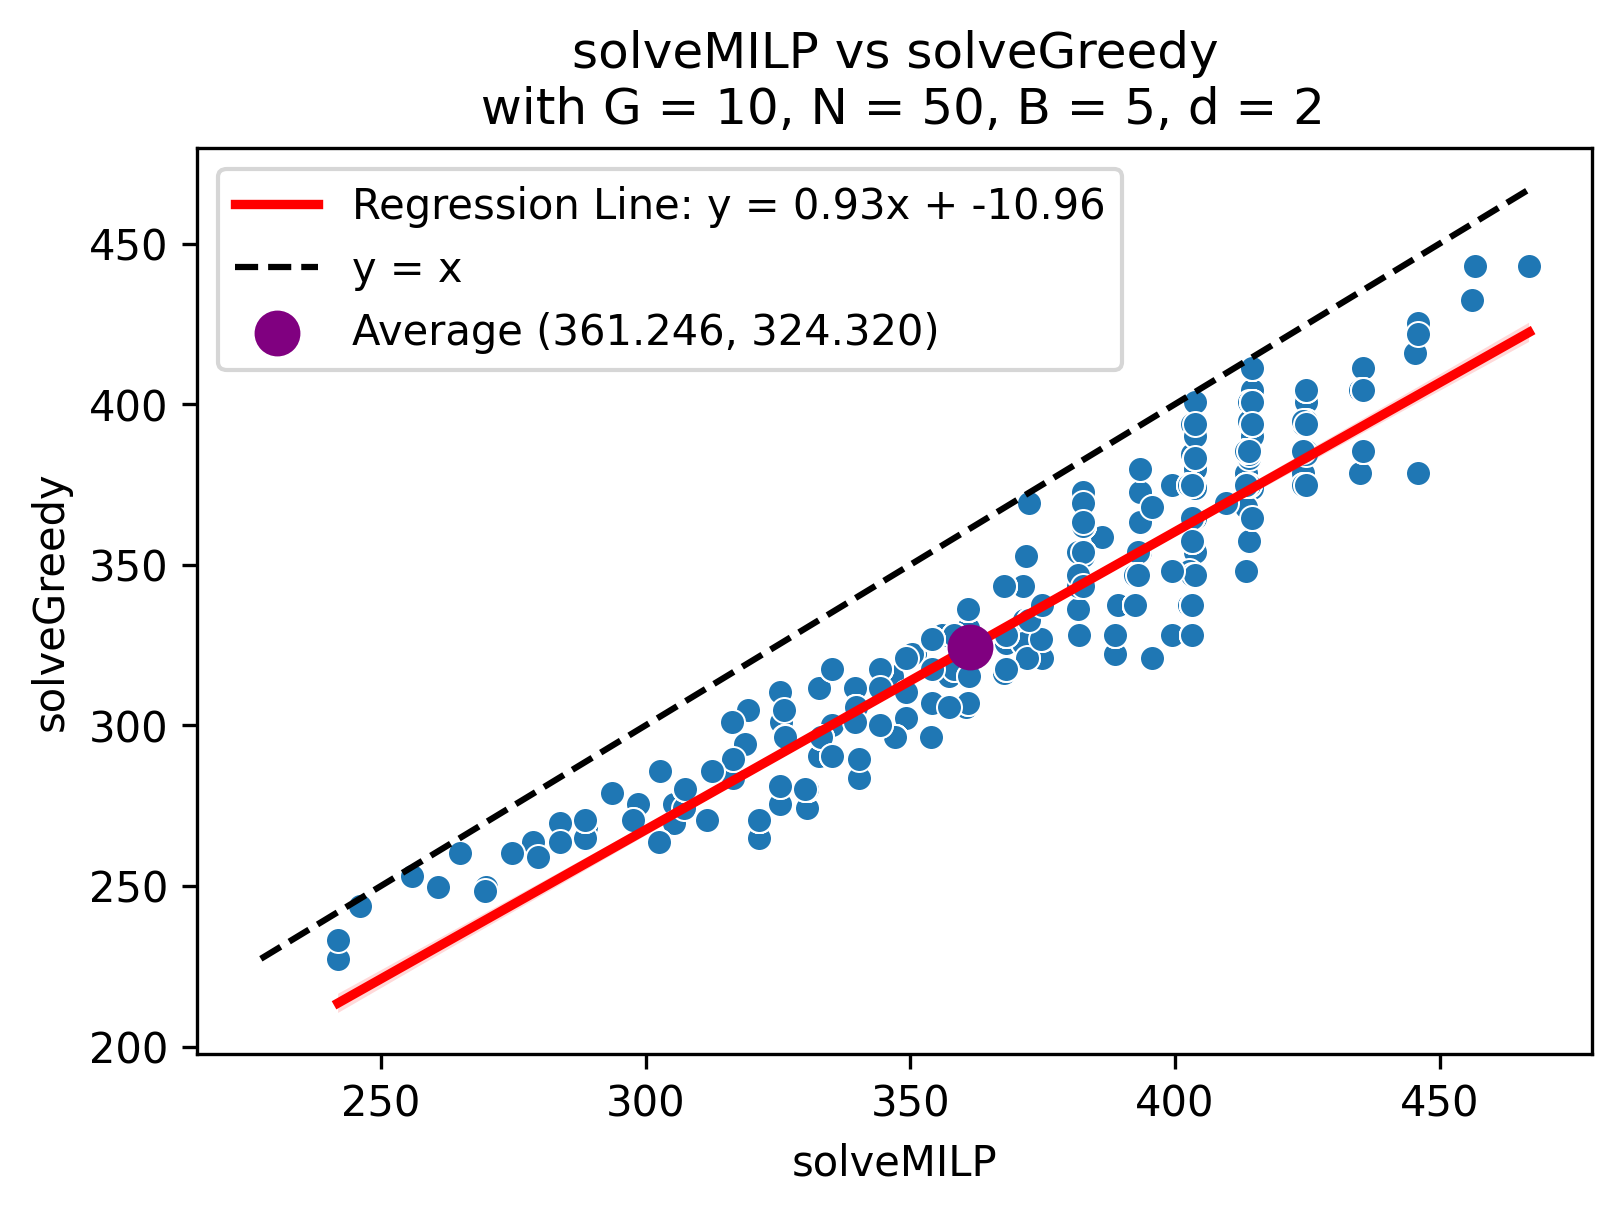

In [66]:
x_func = solveMILP
y_func = solveGreedy
filename = create_filename(N, d, B, G)

# Load the DataFrame from the CSV file
if os.path.exists(filename):
    print(f"Loading data from {filename}")
    df = pd.read_csv(filename)
else:
    print(f"No data found for N={N}, d={d}, B={B}, G={G}. Please generate the data first.")

# Filter the DataFrame to only include rows where both columns have data
df_filtered = df.dropna(subset=[x_func.__name__, y_func.__name__])

# Check if there are enough data points after filtering
if df_filtered.empty:
    print("No data available after filtering for non-null values in both columns.")
else:
    # Fit the linear regression model before plotting
    model = LinearRegression()
    model.fit(df_filtered[[x_func.__name__]], df_filtered[y_func.__name__])
    slope = model.coef_[0]
    intercept = model.intercept_

    # Scatter plot without the regression line initially
    sns.scatterplot(x=df_filtered[x_func.__name__], y=df_filtered[y_func.__name__])

    # Plot the regression line separately and pass the equation to the legend
    sns.regplot(x=df_filtered[x_func.__name__], y=df_filtered[y_func.__name__], scatter=False, color="red", label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')

    # Add the black line y = x
    min_val = min(df_filtered[x_func.__name__].min(), df_filtered[y_func.__name__].min())
    max_val = max(df_filtered[x_func.__name__].max(), df_filtered[y_func.__name__].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='y = x')  # Dashed black line

    # Add a purple dot at the average of x and y values
    avg_x = df_filtered[x_func.__name__].mean()
    avg_y = df_filtered[y_func.__name__].mean()
    plt.scatter(avg_x, avg_y, color='purple', s=100, zorder=5, label=f'Average ({avg_x:.3f}, {avg_y:.3f})')

    # Add labels and title
    plt.xlabel(x_func.__name__)
    plt.ylabel(y_func.__name__)
    plt.title(f'{x_func.__name__} vs {y_func.__name__}\n with G = {G}, N = {N}, B = {B}, d = {d}')

    # Add legend for the new elements
    plt.legend()

    # Save the plot with the desired filename format
    save_filename = f"figures/scatterplots/{x_func.__name__}_{y_func.__name__}_N{N}_B{B}.png"
    plt.savefig(save_filename)
    print(f"Saved plot as {save_filename}")

    # Show plot
    plt.show()


In [77]:
iters = 1000
save_interval = 100  # Save every 100 iterations
uIntegers = True

# Specify the combinations you want to test
target_combinations = [
    {'N': N, 'd': d, 'B': B, 'G': G}
]

# List of functions to test
functions = [
    solveMILP
]  

# Iterate over the target combinations of N, d, B
for combo in target_combinations:
    N = combo['N']
    d = combo['d']
    B = combo['B']
    G = combo['G']
    filename = create_filename(N, d, B, G, uIntegers)
    
    # Check if the CSV file already exists
    if os.path.exists(filename):
        print(f"Loading data from {filename}")
        df = pd.read_csv(filename)    

        # Check if the DataFrame has enough rows
        if len(df) < iters:
            print(f"Existing data has {len(df)} rows, generating additional rows to reach {iters}.")
            needed_rows = iters - len(df)
            results = {f.__name__: [] for f in functions}
            agent_list = []  # List to store created agents
            
            # Generate additional rows
            for i in tqdm(range(needed_rows)):
                agents = create_agents(N, uIntegers)
                agent_list.append(agents)  # Track the created agents
                for func in functions:
                    # Call each function with the appropriate parameters
                    if func.__name__ == 'solveDynamic' or func.__name__ == 'solveStaticOverlap' or func.__name__ == 'solveStaticNonOverlap' or func.__name__ == 'solveConicGibbsGreedyDynamic' or func.__name__ == 'solveMILP':
                        results[func.__name__].append(func(agents, G, B)[1])
                    elif func.__name__ == 'solveStaticNoPool':
                        results[func.__name__].append(func(agents, B))
                    elif func.__name__ == 'solveGreedyDynamic':
                        results[func.__name__].append(func(agents, G, B, d)[1])
                    elif func.__name__ == 'maxUtil':
                        results[func.__name__].append(func(agents))
                
                # Save DataFrame every 100 iterations
                if (i + 1) % save_interval == 0:
                    print(f"Saving progress after {i+1} iterations...")
                    new_rows = pd.DataFrame({
                        'agents': agent_list,  # Store the created agents
                        **results  # Unpack the results dictionary into the DataFrame
                    })
                    df = pd.concat([df, new_rows], ignore_index=True)
                    df.to_csv(filename, index=False)
                    results = {f.__name__: [] for f in functions}  # Reset results
                    agent_list = []  # Reset agent_list
            
            # Append the remaining rows to the DataFrame after the loop
            new_rows = pd.DataFrame({
                'agents': agent_list,  # Store the created agents
                **results  # Unpack the results dictionary into the DataFrame
            })
            df = pd.concat([df, new_rows], ignore_index=True)
        
    else:

        df = pd.DataFrame()

        print(f"Generating data for N={N}, d={d}, B={B}, G={G}")
        
        # Dictionary to store results for each function
        results = {f.__name__: [] for f in functions}
        agent_list = []  # List to store created agents
        
        for i in tqdm(range(iters)):
            agents = create_agents(N, uIntegers)
            agent_list.append(agents)  # Track the created agents
            for func in functions:
                # Call each function with the appropriate parameters
                if func.__name__ == 'solveDynamic' or func.__name__ == 'solveStaticOverlap' or func.__name__ == 'solveStaticNonOverlap' or func.__name__ == 'solveConicGibbsGreedyDynamic' or func.__name__ == 'solveMILP':
                    results[func.__name__].append(func(agents, G, B)[1])
                elif func.__name__ == 'solveStaticNoPool':
                    results[func.__name__].append(func(agents, B))
                elif func.__name__ == 'solveGreedyDynamic':
                    results[func.__name__].append(func(agents, G, B, d)[1])
                elif func.__name__ == 'maxUtil':
                    results[func.__name__].append(func(agents))
            
            # Save DataFrame every 100 iterations
            if (i + 1) % save_interval == 0:
                print(f"Saving progress after {i+1} iterations...")
                new_rows = pd.DataFrame({
                    'agents': agent_list,  # Store the created agents
                    **results  # Unpack the results dictionary into the DataFrame
                })
                df = pd.concat([df, new_rows], ignore_index=True)
                df.to_csv(filename, index=False)
                results = {f.__name__: [] for f in functions}  # Reset results
                agent_list = []  # Reset agent_list
        
        # Save the final DataFrame at the end of the loop
        new_rows = pd.DataFrame({
            'agents': agent_list,  # Store the created agents
            **results  # Unpack the results dictionary into the DataFrame
        })
        df = pd.concat([df, new_rows], ignore_index=True)
    
    # Save the DataFrame to CSV
    df.to_csv(filename, index=False)


Generating data for N=50, d=2, B=10, G=5


  0%|          | 0/1000 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-03

Interrupt request received


In [59]:
# Load the CSV file into a DataFrame
df = pd.read_csv(create_filename(N, d, B, G))

# List of columns for which to calculate the average
columns = [
    'solveIndModel', 'solveNN', 'solveDynamic',
    'solveStaticOverlap', 'solveStaticNonOverlap',
    'solveStaticNoPool', 'solveGreedyDynamic', 'maxUtil'
]

# Calculate the average for each specified column
averages = df[columns].mean()

# Print the results
print(averages)

# Convert the averages to a DataFrame for better formatting
averages_df = pd.DataFrame(averages, columns=['Average'])

# Create a LaTeX table and format the caption with values N, B, G, and d
latex_table = averages_df.to_latex(index=True, caption=f'Average values for N = {N}, B = {B}, G = {G}, d = {d}', label='tab:averages')

# Print the LaTeX table
print(latex_table)

solveIndModel            0.567222
solveNN                  0.810873
solveDynamic             1.152322
solveStaticOverlap       1.136059
solveStaticNonOverlap    1.125750
solveStaticNoPool        1.095220
solveGreedyDynamic       1.150540
maxUtil                  1.265537
dtype: float64
\begin{table}
\centering
\caption{Average values for N = 5, B = 3, G = 5, d = 2}
\label{tab:averages}
\begin{tabular}{lr}
\toprule
{} &   Average \\
\midrule
solveIndModel         &  0.567222 \\
solveNN               &  0.810873 \\
solveDynamic          &  1.152322 \\
solveStaticOverlap    &  1.136059 \\
solveStaticNonOverlap &  1.125750 \\
solveStaticNoPool     &  1.095220 \\
solveGreedyDynamic    &  1.150540 \\
maxUtil               &  1.265537 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_541/288597340.py:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = averages_df.to_latex(index=True, caption=f'Average values for N = {N}, B = {B}, G = {G}, d = {d}', label='tab:averages')


In [61]:
# Initialize tqdm with pandas
tqdm.pandas()

# Load the CSV file
data_path = create_filename(N,d,B,G)
df = pd.read_csv(data_path)

# Process each row to call solveConicGibbsGreedyDynamic on the agents and store the result in a new column, with a progress bar
df['solveMILP'] = df['agents'].progress_apply(lambda x: solveMILP(ast.literal_eval(x), B=B, G=G)[1])

# Save the updated DataFrame back to a new CSV file (or overwrite the existing one)
df.to_csv(data_path, index=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-15


In [62]:
from tqdm import tqdm
import pandas as pd
import ast

# Initialize tqdm with pandas
tqdm.pandas()

# Load the CSV file
data_path = create_filename(N, d, B, G)
df = pd.read_csv(data_path)

# Process only the first 100 rows to call solveConicGibbsGreedyDynamic on the agents and store the result in a new column, with a progress bar
df.loc[:99, 'solveConicGibbsGreedyDynamic'] = df.loc[:99, 'agents'].progress_apply(lambda x: solveConicGibbsGreedyDynamic(ast.literal_eval(x), B=B, G=G)[1])

# Save the updated DataFrame back to the CSV file
df.to_csv(data_path, index=False)

100%|██████████| 100/100 [1:16:39<00:00, 45.99s/it]


In [96]:
# Initialize tqdm with pandas
tqdm.pandas()

# Load the CSV file
data_path = create_filename(N, d, B, G)
df = pd.read_csv(data_path)

# Process only the first 100 rows to call solveConicGibbsGreedyDynamic on the agents and store the result in a new column, with a progress bar
df.loc[:99, 'solveConicGibbsGreedyDynamic'] = df.loc[:99, 'agents'].progress_apply(lambda x: solveConicGibbsGreedyDynamic(ast.literal_eval(x), B=B, G=G)[1])

# Save the updated DataFrame back to the CSV file
df.to_csv(data_path, index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [97]:
def plot_results_compare(x_func, y_func, combo, compare):
    N = combo['N']
    d = combo['d']
    B = combo['B']
    G = combo['G']
    
    # Create the filename based on the provided combination and functions
    filename = create_filename(N, d, B, G)
    
    # Load the DataFrame from the CSV file
    if os.path.exists(filename):
        print(f"Loading data from {filename}")
        df = pd.read_csv(filename)
    else:
        print(f"No data found for N={N}, d={d}, B={B}, G={G}. Please generate the data first.")
        return
    
    # Create a new column for color mapping based on the condition
    df['color'] = df[compare.__name__] > df[x_func.__name__]
    
    # Scatter plot with conditional coloring
    sns.scatterplot(x=df[x_func.__name__], y=df[y_func.__name__], hue=df['color'], palette={True: 'green', False: sns.color_palette()[0]}, legend=False)
    
    # Fit the linear regression model before plotting
    model = LinearRegression()
    model.fit(df[[x_func.__name__]], df[y_func.__name__])
    slope = model.coef_[0]
    intercept = model.intercept_

    # Plot the regression line and add the equation to the legend
    sns.regplot(x=df[x_func.__name__], y=df[y_func.__name__], scatter=False, color="red", label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')
    
    # Add the black line y = x
    min_val = min(df[x_func.__name__].min(), df[y_func.__name__].min())
    max_val = max(df[x_func.__name__].max(), df[y_func.__name__].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='y = x')  # Dashed black line
    
    # Add a purple dot at the average of x and y values
    avg_x = df[x_func.__name__].mean()
    avg_y = df[y_func.__name__].mean()
    plt.scatter(avg_x, avg_y, color='purple', s=100, zorder=5, label=f'Average ({avg_x:.3f}, {avg_y:.3f})')
    
    # Add labels and title
    plt.xlabel(x_func.__name__)
    plt.ylabel(y_func.__name__)
    plt.title(f'{x_func.__name__} vs {y_func.__name__}\n with G = {G}, N = {N}, B = {B}, d = {d}\n Green points are where {compare.__name__} > {x_func.__name__}')
    
    # Add legend for the new elements
    plt.legend()
    
    # Save the plot with the desired filename format
    save_filename = f"figures/scatterplots/{x_func.__name__}_{y_func.__name__}_N{N}_B{B}.png"
    plt.savefig(save_filename, bbox_inches='tight')
    print(f"Saved plot as {save_filename}")
    
    # Show plot
    plt.show()

In [130]:
def plot_results(x_func, y_func, combo):
    N = combo['N']
    d = combo['d']
    B = combo['B']
    G = combo['G']
    
    # Create the filename based on the provided combination and functions
    filename = create_filename(N, d, B, G)
    
    # Load the DataFrame from the CSV file
    if os.path.exists(filename):
        print(f"Loading data from {filename}")
        df = pd.read_csv(filename)
    else:
        print(f"No data found for N={N}, d={d}, B={B}, G={G}. Please generate the data first.")
        return
    
    # Fit the linear regression model before plotting
    model = LinearRegression()
    model.fit(df[[x_func.__name__]], df[y_func.__name__])
    slope = model.coef_[0]
    intercept = model.intercept_

    # Scatter plot without the regression line initially
    sns.scatterplot(x=df[x_func.__name__], y=df[y_func.__name__])
    
    # Plot the regression line separately and pass the equation to the legend
    sns.regplot(x=df[x_func.__name__], y=df[y_func.__name__], scatter=False, color="red", label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')
    
    # Add the black line y = x
    min_val = min(df[x_func.__name__].min(), df[y_func.__name__].min())
    max_val = max(df[x_func.__name__].max(), df[y_func.__name__].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='y = x')  # Dashed black line
    
    # Add a purple dot at the average of x and y values
    avg_x = df[x_func.__name__].mean()
    avg_y = df[y_func.__name__].mean()
    plt.scatter(avg_x, avg_y, color='purple', s=100, zorder=5, label=f'Average ({avg_x:.3f}, {avg_y:.3f})')
    
    # Add labels and title
    plt.xlabel(x_func.__name__)
    plt.ylabel(y_func.__name__)
    plt.title(f'{x_func.__name__} vs {y_func.__name__}\n with G = {G}, N = {N}, B = {B}, d = {d}')
    
    # Add legend for the new elements
    plt.legend()
    
    # Save the plot with the desired filename format
    save_filename = f"figures/scatterplots/{x_func.__name__}_{y_func.__name__}_N{N}_B{B}.png"
    plt.savefig(save_filename)
    print(f"Saved plot as {save_filename}")
    
    # Show plot
    plt.show()

# Example combos to test the plotting function
combos = [{'N': 3, 'd': 2, 'B': 2, 'G': 3}, {'N': 5, 'd': 2, 'B': 3, 'G': 5}]
for combo in combos:
    # plot_results(solveStaticNonOverlap, solveStaticNoPool, combo)
    # plot_results(solveDynamic, solveStaticOverlap, combo)
    # plot_results(solveDynamic, solveGreedyDynamic, combo)
    # plot_results(solveDynamic, maxUtil, combo)
    # plot_results(solveStaticOverlap, solveStaticNonOverlap, combo)
    # plot_results(solveDynamic, solveNN, combo)
    # plot_results(solveStaticNonOverlap, solveNN, combo)
    # plot_results(solveStaticOverlap, solveNN, combo)
    # plot_results_compare(solveGreedyDynamic, solveNN, combo, solveDynamic)
    plot_results(solveDynamic, solveConicGibbsGreedyDynamic, combo)
    plot_results(solveStaticNonOverlap, solveConicGibbsGreedyDynamic, combo)
    plot_results(solveStaticOverlap, solveConicGibbsGreedyDynamic, combo)
    # plot_results_compare(solveGreedyDynamic, solveIndModel, combo, solveDynamic)
    plot_results(solveNN, solveConicGibbsGreedyDynamic, combo)
    plot_results(solveIndModel, solveConicGibbsGreedyDynamic, combo)

Loading data from data/types/data_N3_d2_B2_G3.csv


KeyError: 'solveConicGibbsGreedyDynamic'

Loading data from data/data_N5_d2_B3_G5.csv
Saved plot as figures/solveGreedyDynamic_solveNN_N5_B3.png


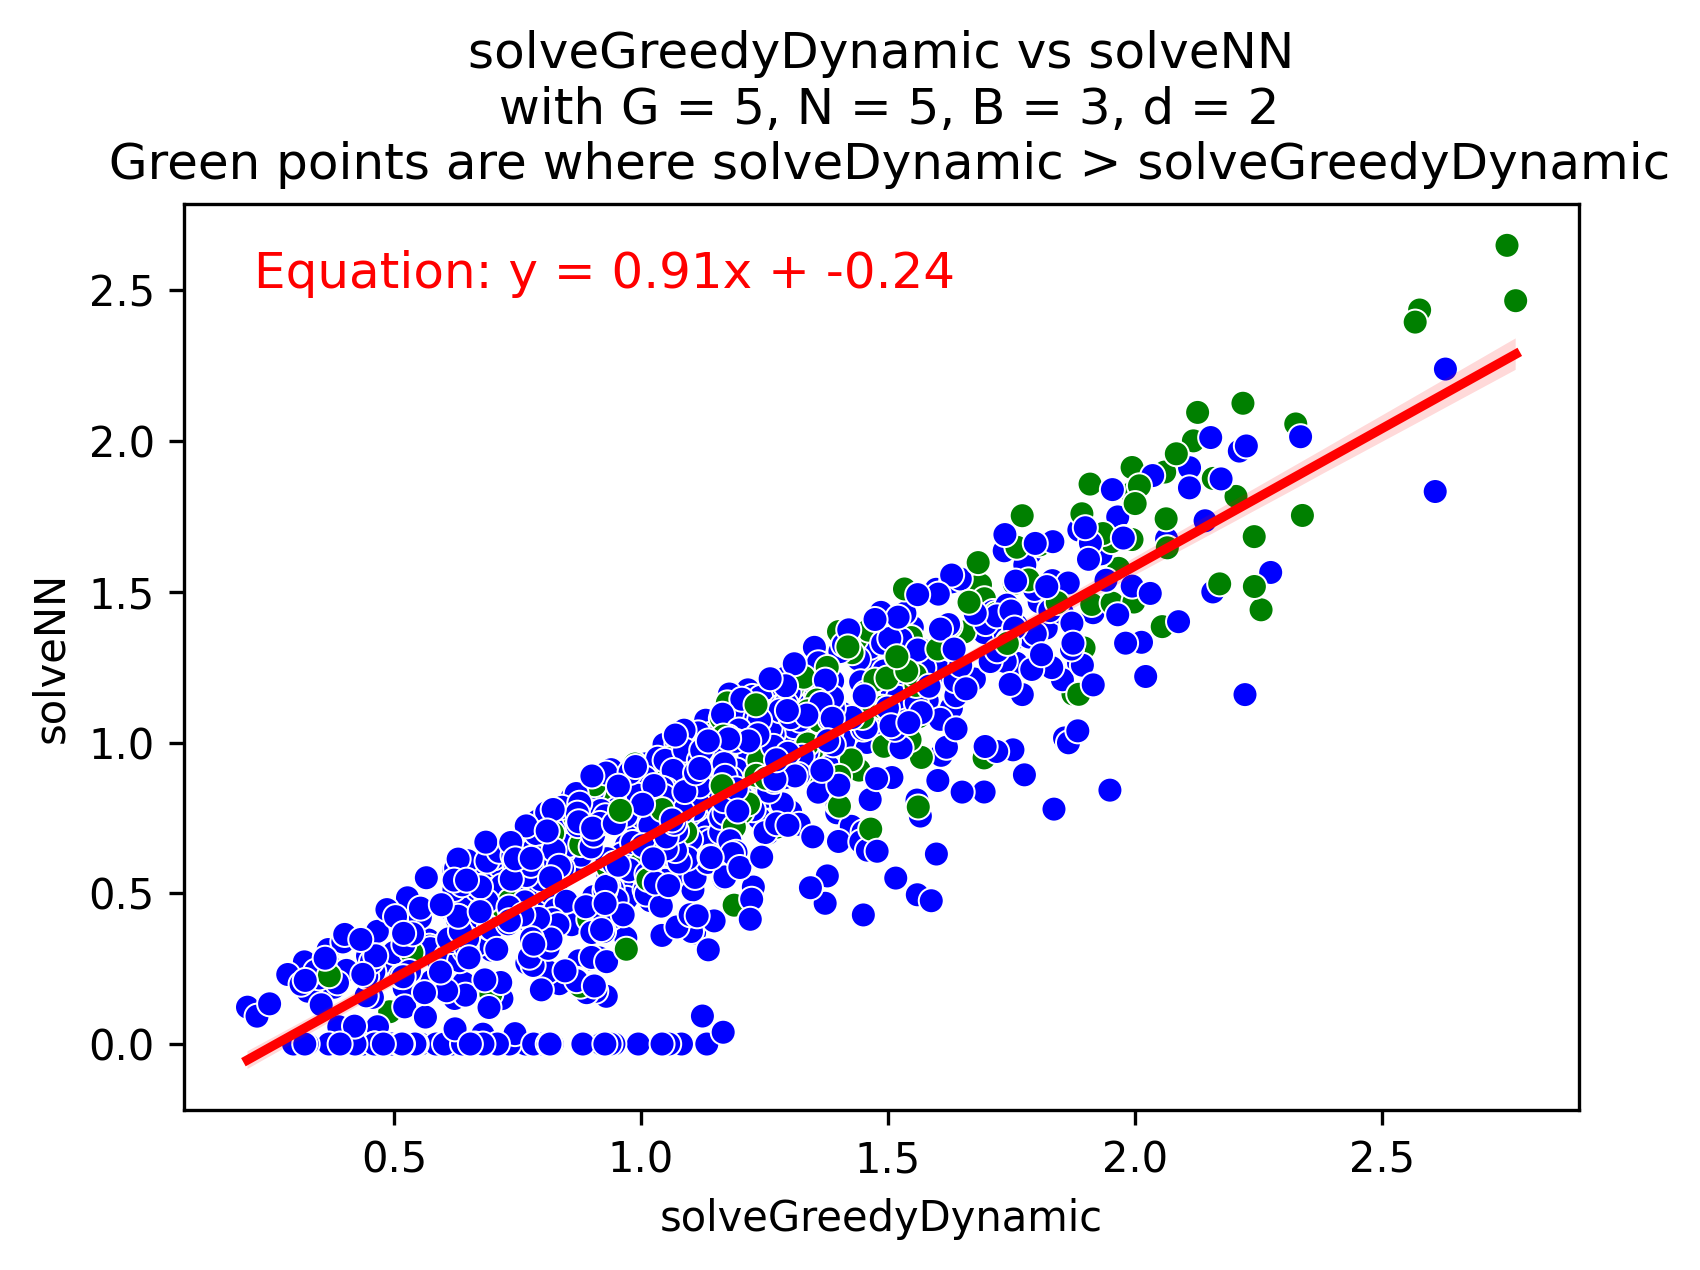

In [190]:
def create_filename(N, d, B, G):
    return os.path.join(data_folder, f"data_N{N}_d{d}_B{B}_G{G}.csv")

data_folder = 'data'

def plot_results(x_func, y_func, combo, compare):
    N = combo['N']
    d = combo['d']
    B = combo['B']
    G = combo['G']
    
    # Create the filename based on the provided combination and functions
    filename = create_filename(N, d, B, G)
    
    # Load the DataFrame from the CSV file
    if os.path.exists(filename):
        print(f"Loading data from {filename}")
        df = pd.read_csv(filename)
    else:
        print(f"No data found for N={N}, d={d}, B={B}, G={G}. Please generate the data first.")
        return
    
    # Create a new column for color mapping based on the condition
    df['color'] = df[compare.__name__] > df[x_func.__name__]
    
    # Scatter plot with conditional coloring
    sns.scatterplot(x=df[x_func.__name__], y=df[y_func.__name__], hue=df['color'], palette={True: 'green', False: 'blue'}, legend=False)

    # Fit the line
    sns.regplot(x=df[x_func.__name__], y=df[y_func.__name__], scatter=False, color="red")
    
    # Linear regression to get the equation of the line
    model = LinearRegression()
    model.fit(df[[x_func.__name__]], df[y_func.__name__])
    slope = model.coef_[0]
    intercept = model.intercept_

    # Add labels, title, and equation
    plt.xlabel(x_func.__name__)
    plt.ylabel(y_func.__name__)
    plt.title(f'{x_func.__name__} vs {y_func.__name__}\n with G = {G}, N = {N}, B = {B}, d = {d}\n Green points are where {compare.__name__} > {x_func.__name__}')
    plt.text(
        0.05, 0.95,
        f'Equation: y = {slope:.2f}x + {intercept:.2f}',
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        color='red'
    )
    
    # Save the plot with the desired filename format
    save_filename = f"figures/{x_func.__name__}_{y_func.__name__}_N{N}_B{B}.png"
    plt.savefig(save_filename)
    print(f"Saved plot as {save_filename}")
    
    # Show plot
    plt.show()

# Example combos to test the plotting function
combos = [{'N': 5, 'd': 2, 'B': 3, 'G': 5}]
for combo in combos:
    plot_results(solveGreedyDynamic, solveNN, combo, solveDynamic)


### Agent Types

In [55]:
def create_types(numsOfEach, U, Q):
  agents = list()

  # for each i in numsOfEach:
  # N[i] agents of (U[i], Q[i]) utility and health tuples

  for i in range(len(numsOfEach)):
    for j in range(numsOfEach[i]):
      agents.append((f"Type {i} and User {j}", U[i], Q[i]))
  return agents

In [60]:
numsOfEach = [1] * 9
U = [25 * i for i in range(1, 4)] * 3
Q = [0.25 * i for i in range(1, 4) for _ in range(3)]

agents = create_types(numsOfEach, U, Q)
agents


[('Type 0 and User 0', 25, 0.25),
 ('Type 1 and User 0', 50, 0.25),
 ('Type 2 and User 0', 75, 0.25),
 ('Type 3 and User 0', 25, 0.5),
 ('Type 4 and User 0', 50, 0.5),
 ('Type 5 and User 0', 75, 0.5),
 ('Type 6 and User 0', 25, 0.75),
 ('Type 7 and User 0', 50, 0.75),
 ('Type 8 and User 0', 75, 0.75)]

In [92]:
N = 50
B = 10
d = 2
G = 5

# Load the CSV file
data_path = f'data/types/data_N{N}_d{d}_B{B}_G{G}.csv'

In [128]:
## every combo

agentCombos = [list(combo) for combo in itertools.combinations_with_replacement(agents, N)]

# Generate new tuples where the agent ID is replaced by an integer 0 through N-1
newAgentCombos = []

for combo in agentCombos:
    newCombo = [(idx,agent[1], agent[2]) for idx, agent in enumerate(combo)]  # Create new tuple with integer IDs
    newAgentCombos.append(newCombo)

with open(data_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow(['agents'])
    
    # Write each combination on a new row
    for combo in newAgentCombos:
        writer.writerow([combo])  # Writing the list as one column in the row

In [62]:
## random sample

# Number of iterations (rows) you want to sample
iter = 1000  # You can adjust this based on how many rows you want

# Sample N agents from the list 'agents' with replacement iter times
newAgentCombos = []

for _ in range(iter):
    sampled_combo = random.choices(agents, k=N)  # Randomly sample N agents with replacement
    newCombo = [(idx, agent[1], agent[2]) for idx, agent in enumerate(sampled_combo)]  # Create new tuple with integer IDs
    newAgentCombos.append(newCombo)

# Writing the sampled combinations to a CSV file
with open(data_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow(['agents'])
    
    # Write each combination on a new row
    for combo in newAgentCombos:
        writer.writerow([combo])  # Writing the list as one column in the row

In [55]:
tqdm.pandas()

# Read the CSV file
df = pd.read_csv(data_path)

# Use progress_apply instead of apply to show the progress bar
df['solveConicGibbsGreedyDynamic'] = df['agents'].progress_apply(lambda x: solveConicGibbsGreedyDynamic(ast.literal_eval(x), B=B, G=G)[1])

# Save the modified DataFrame back to the CSV file
df.to_csv(data_path, index=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [178]:
functions = [
    solveDynamic, 
    solveStaticOverlap, 
    solveStaticNonOverlap, 
    solveStaticNoPool, 
    solveGreedyDynamic, 
    maxUtil
]  

df = pd.read_csv(data_path)

df['solveIndModel'] = df['agents'].apply(lambda x: solveIndModel(ast.literal_eval(x), B = B, G = G))
df['solveNN'] = df['agents'].apply(lambda x: solveNN(ast.literal_eval(x), B = B, G = G))

# Register tqdm with pandas
tqdm.pandas()

# For each function in the list, apply the appropriate operation
for func in functions:
    # Call each function with the appropriate parameters
    if func.__name__ == 'solveDynamic' or func.__name__ == 'solveStaticOverlap' or func.__name__ == 'solveStaticNonOverlap':
        df[func.__name__] = df['agents'].progress_apply(lambda x: func(ast.literal_eval(x), G=G, B=B)[1])
    elif func.__name__ == 'solveStaticNoPool':
        df[func.__name__] = df['agents'].progress_apply(lambda x: func(ast.literal_eval(x), B=B))
    elif func.__name__ == 'solveGreedyDynamic':
        df[func.__name__] = df['agents'].progress_apply(lambda x: func(ast.literal_eval(x), G=G, B=B, d=d)[1])
    elif func.__name__ == 'maxUtil':
        df[func.__name__] = df['agents'].progress_apply(lambda x: func(ast.literal_eval(x)))


df.to_csv(data_path, index=False)


  0%|          | 0/1287 [00:00<?, ?it/s]

  0%|          | 0/1287 [00:00<?, ?it/s]

  0%|          | 0/1287 [00:00<?, ?it/s]

  0%|          | 0/1287 [00:00<?, ?it/s]

  0%|          | 0/1287 [00:00<?, ?it/s]

  0%|          | 0/1287 [00:00<?, ?it/s]

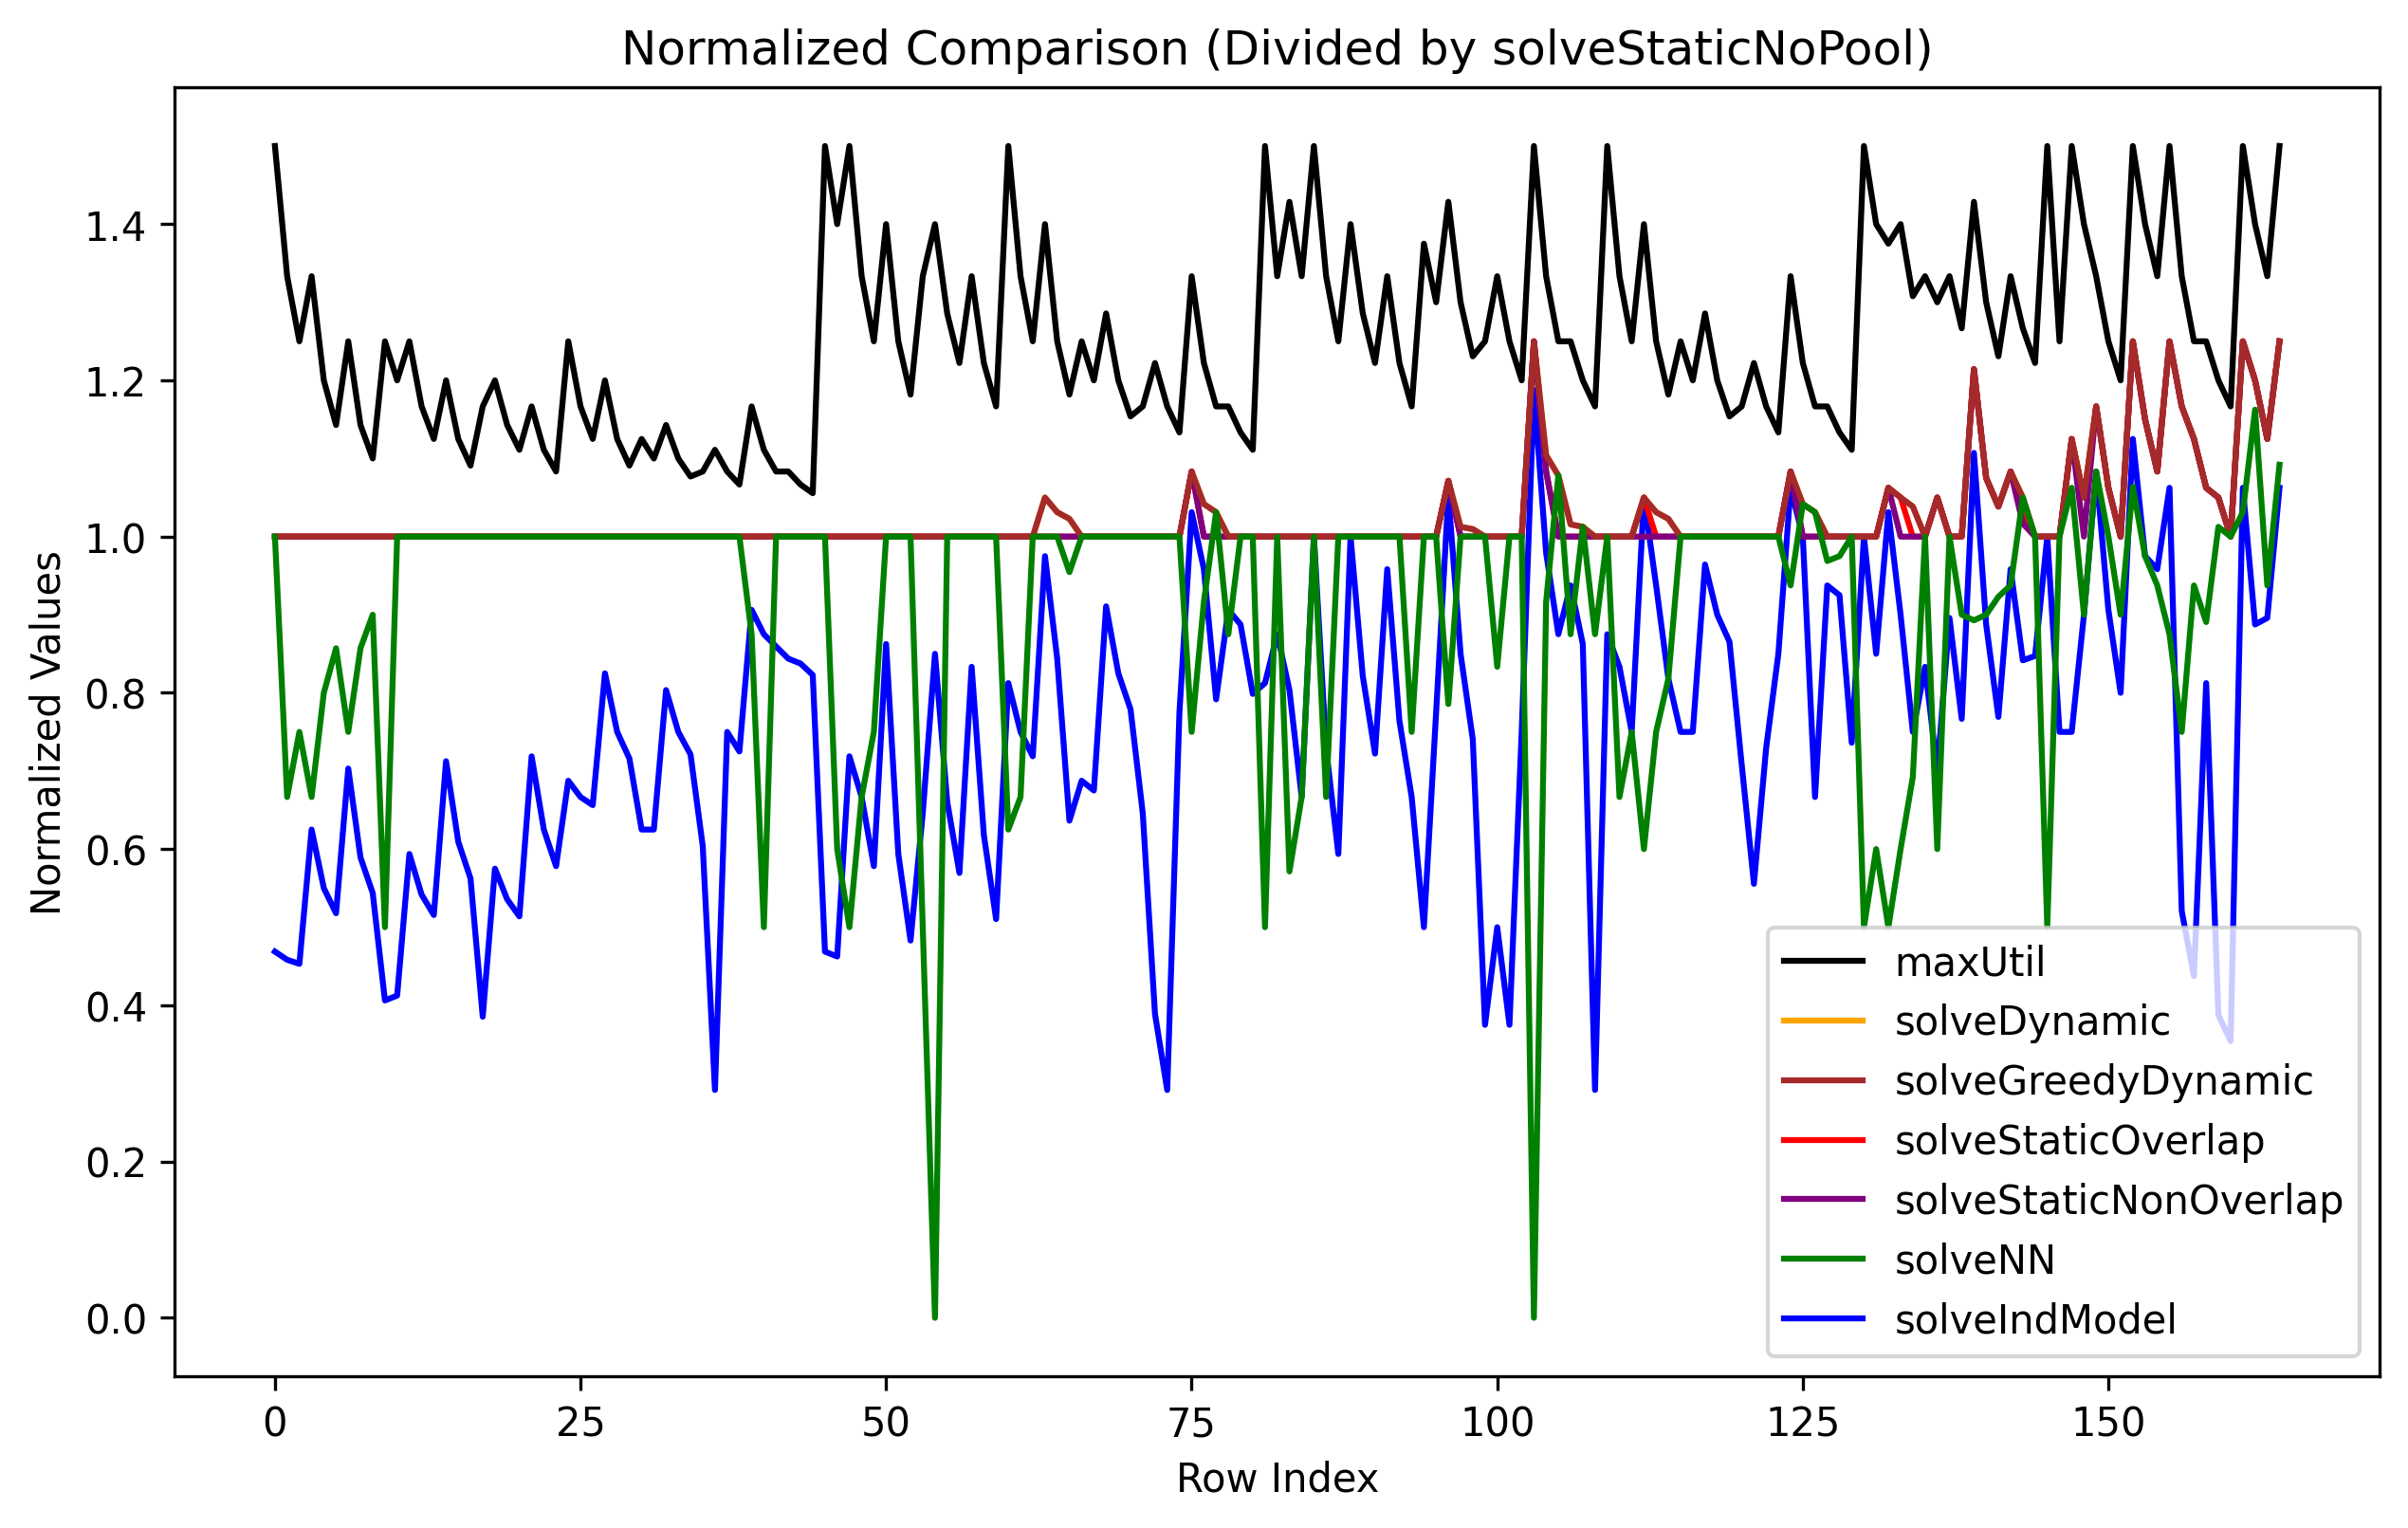

In [211]:
df = pd.read_csv(data_path)

# Drop the 'agents' column
df = df.drop(columns=['agents'])

# Normalize by dividing each value by the corresponding 'solveStaticNoPool' value
normalized_df = df.div(df['solveStaticNoPool'], axis=0)

avg_values = normalized_df.mean().sort_values(ascending=False)

# Plotting the normalized data
plt.figure(figsize=(10, 6))

colors = {
    'solveIndModel': 'blue',
    'solveDynamic': 'orange',
    'solveStaticOverlap': 'red',
    'solveStaticNonOverlap': 'purple',
    'solveGreedyDynamic': 'brown',
    'maxUtil': 'black',
    'solveNN': 'green'
}

# Plot each solver's normalized data with specific colors
for column in normalized_df.columns:
    if column != 'solveStaticNoPool':  # Exclude 'solveStaticNoPool' as it will be 1 for all rows
        plt.plot(normalized_df.index, normalized_df[column], label=column, color=colors.get(column, 'black'))


# Adding labels and title
plt.xlabel('Row Index')
plt.ylabel('Normalized Values')
plt.title('Normalized Comparison (Divided by solveStaticNoPool)')
# Sort legend by the average value
handles, labels = plt.gca().get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: avg_values[x[1]], reverse=True)
handles, labels = zip(*sorted_handles_labels)

plt.legend(handles, labels)  # Add the sorted legend

output_path = os.path.join('figures/types', f'types_N{N}_B{B}.png')
plt.savefig(output_path)

#### Custom Type Testing

In [ ]:
N = [5, 5]
U = [1, 1]
Q = [1/3, 1/2]

G = sum(N)
B = 2

agents = create_types(N, U, Q)

In [ ]:
staticStrategy, staticUtility = solveStaticOverlap(agents, G, B)
dynamicStrategy, dynamicUtility = solveDynamic(agents, G, B)

In [ ]:
print(f"Ratio: {dynamicUtility/staticUtility}")
printDynamic(dynamicStrategy, dynamicUtility)
printStatic(staticStrategy, staticUtility)

## Appendix

### Old Gibbs MCMC Code

In [ ]:
# Gibbs MCMC algorithm for binary agent states
def oldGibbsMCMC(agents, posGroups, negAgents, iterations=1000, burn_in=250):

    # Initialize agents with binary states (0: healthy, 1: infected), ensuring negAgents are always healthy
    def initialize_agents_binary(agents, negAgents):
        return {agent[0]: 0 if agent[0] in negAgents else np.random.choice([0, 1], p=[agent[2], 1-agent[2]]) for agent in agents}

    # Gibbs-like sampling: Update one agent's state given the rest of the current states
    def update_agent_state(agent, posGroups, health_states, agent_prob, negAgents):
        """Update the state of the agent (0: healthy, 1: infected) based on the group constraints."""
        if agent in negAgents:
            return 0  # If the agent is in negAgents, they must always be healthy
        
        relevant_groups = [group for group in posGroups if agent in group]

        must_be_infected = False
        for group in relevant_groups:
            if all(health_states[other] == 0 for other in group if other != agent):
                must_be_infected = True
                break  # Short-circuit the loop
        
        if must_be_infected:
            return 1  # The agent must be infected to satisfy the group constraint
        else:
            # Otherwise, use their probability of being healthy (agent_prob)
            return bernoulli.rvs(1 - agent_prob)


    """Perform MCMC to update health states (binary: 0 or 1) and calculate probabilities."""
    # Initialize binary health states (0: healthy, 1: infected), ensuring negAgents are always healthy
    health_states = initialize_agents_binary(agents, negAgents)
    
    # Store counts of healthy samples for each agent
    healthy_counts = {agent[0]: 0 for agent in agents}
    
    # Run MCMC iterations
    for iteration in range(iterations):
        for agent in agents:
            # Update the state of each agent given the current states, except for agents in negAgents
            health_states[agent[0]] = update_agent_state(agent[0], posGroups, health_states, agent[2], negAgents)
        
        # After burn-in, record the number of times each agent is healthy
        if iteration >= burn_in:
            for agent in agents:
                if health_states[agent[0]] == 0:
                    healthy_counts[agent[0]] += 1
    
    # Calculate the final probabilities of being healthy
    total_samples = iterations - burn_in
    final_probs = {agent[0]: healthy_counts[agent[0]] / total_samples for agent in agents}

    # Prepare the agentDict to return, setting utility to 0 for negAgents
    agentDict = {}
    for agent in agents:
        agent_id = agent[0]
        if agent_id in negAgents:
            agentDict[agent_id] = (0, 1)  # Utility is 0, always healthy
        else:
            agentDict[agent_id] = (agent[1], final_probs[agent_id])  # Utility remains the same, update health probability

    return agentDict

### Old Dif. Ev. Code

In [ ]:
# greedy dynamic vs. dynamic

# Define your objective function (the 'ratio' function)
def ratio(x):
  agents = [(0, x[0], x[1]), (1, x[2], x[3]), (2, x[4], x[5])]
  return -solveDynamic(agents)[1]/solveGreedyDynamic(agents)[1]

# Define the bounds for each input variable (assuming they are all between 0 and 1)
bounds = [(0, 1)] * 6

# Run global optimization using differential evolution
result = differential_evolution(ratio, bounds)

# Retrieve the optimal solution
optimal_solution = result.x
optimal_value = result.fun

agents = [(0, optimal_solution[0], optimal_solution[1]), (1, optimal_solution[2], optimal_solution[3]), (2, optimal_solution[4], optimal_solution[5])]
greedyDynamicStrategy, greedyDynamicUtility = solveGreedyDynamic(agents)
dynamicStrategy, dynamicUtility = solveDynamic(agents)
maxUtility = maxUtil(agents)
print(f"We have agents {agents}.")
printDynamic(dynamicStrategy, dynamicUtility)
printDynamic(greedyDynamicStrategy, greedyDynamicUtility, greedy=True)
print(f"\nRatio: {dynamicUtility/greedyDynamicUtility}")
print(f"\nMaximum Utility: {maxUtility}")

### Incorrect Use of Bayes' Theorem

In [ ]:
def bayesTheorem(agents, posGroups, negAgents):

  posGroups = list(posGroups)
  posGroups = sorted(posGroups, key=len)

  newAgents = []

  for agent in agents:
    if agent[0] in set(negAgents):
      newAgents.append((agent[0], 0, 1))
    else:
      newAgents.append(agent)

  agentDict = {}
  for agent in newAgents:
    agentDict[agent[0]] = (agent[1], agent[2])

  def genSubsets(posGroups):
    subsets = []
    for i in range(1, 2**len(posGroups)):
      subset = [posGroups[j] for j in range(len(posGroups)) if (i >> j) & 1]
      subsets.append(subset)

    return subsets

  subsets = genSubsets(posGroups)

  probIntersectPos = {}

  for subset in subsets:

    healthy = 1

    intersect = list(set.intersection(*[set(s) for s in subset]))

    for person in intersect:
      healthy *= agentDict[person][1]

    probIntersectPos[tuple(subset)] = 1 - healthy

  probPos = {}
  probPos[tuple(posGroups)] = 0 if len(subsets) > 0 else 1
  for subset in subsets:
    if len(subset) % 2 == 0:
      probPos[tuple(posGroups)] -= probIntersectPos[tuple(subset)]
    else:
      probPos[tuple(posGroups)] += probIntersectPos[tuple(subset)]

  # finalAgents = []

  for agent in newAgents:

    # P(agent is Pos | posGroups) = P(posGroups | agent is Pos) * P(agent in Pos) / P(posGroups)
    # = P(pos Groups agent not in) * P(agent is Pos) / P(posGroups)

    if agent[2] == 1 or agent[2] == 0:
      # finalAgents.append(agent)
      agentDict[agent[0]] = (agent[1], agent[2])
    else:

      posNotIn = [posGroup for posGroup in posGroups if agent[0] not in posGroup]

      if tuple(posNotIn) not in probPos:

        subsets = genSubsets(posNotIn)
        probPos[tuple(posNotIn)] = 0 if len(subsets) > 0 else 1
        for subset in subsets:
          if len(subset) % 2 == 0:
            probPos[tuple(posNotIn)] -= probIntersectPos[tuple(subset)]
          else:
            probPos[tuple(posNotIn)] += probIntersectPos[tuple(subset)]

      pAgentPos = probPos[tuple(posNotIn)] * (1 - agent[2]) / probPos[tuple(posGroups)]
      health = 1 - pAgentPos

      # finalAgents.append((agent[0], agent[1], health))
      agentDict[agent[0]] = (agent[1], health)

  # for agent in finalAgents:
  #   agentDict[agent[0]] = (agent[1], agent[2])

  return agentDict

### Using Dictionaries for Agents

In [ ]:
# dictionary of (utility, probability of healthy) dictionaries with ID as key

def create_agents(n = n):
  agents = dict()

  for id in range(n):
    agents[id] = {"utility" : random.random(), "healthy" : random.random()}
  return agents

agents = create_agents()

print(agents)

In [ ]:
def maxUtil(agents):
  util = 0
  for id in agents:
    util += agents[id]['utility'] * agents[id]['healthy']
  return util

In [ ]:
def solveStaticNoPool(agents, B=B):
  utils = []
  for id in agents:
    utils.append(agents[id]['utility'] * agents[id]['healthy'])
  utils = sorted(utils, reverse=True)
    # Take the first B elements and sum them
  util = sum(utils[:B])
  return util

In [ ]:
def solveStaticNonOverlap(agents, G = G, B = B):

  def generate_non_overlapping_subsets(agents, G, B):
    # Generate all possible subsets of agents with sizes up to G
    subsets = []
    for r in range(1, G+1):
        subsets.extend(combinations(agents, r))

    # Generate combinations of B non-overlapping subsets
    combos = combinations(subsets, B)

    # Filter combinations to keep only non-overlapping ones
    non_overlapping_combinations = []
    for combination in combos:
        combined_set = set()
        is_non_overlapping = True
        for subset in combination:
            if combined_set.intersection(subset):
                is_non_overlapping = False
                break
            combined_set.update(subset)
        if is_non_overlapping:
            non_overlapping_combinations.append(combination)

    return non_overlapping_combinations

  def strategyUtilitySNO(combination):
    utility = 0
    for group in combination:
      groupUtility = 0
      groupHealthy = 1
      for id in group:
        groupUtility += agents[id]['utility']
        groupHealthy *= agents[id]['healthy']
      utility += groupHealthy * groupUtility
    return utility

  strategy = dict()
  combos = generate_non_overlapping_subsets(agents, G, B)
  for combination in combos:
    strategy[combination] = strategyUtilitySNO(combination)
  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

### Alternate Print for Dynamic

In [ ]:
def printDynamic(strategy, utility = 0):
  if utility > 0:
    print(f"\nDynamic Strategy, Utility {utility}:")
  for i in range(math.floor(len(strategy)/3)):
    print(f"Test {i * 3 + 1}: {strategy[i]}")
    if strategy[i+1]:
      print(f"If positive, test {strategy[i+1]}")
    if strategy[i+2]:
      print(f"If negative, test {strategy[i+2]}")

### Solve Static Overlap by Enumeration

In [ ]:
def solveStaticOverlap(agents, G = G, B = B):

  def generate_overlapping_subsets(agents, G, B):

    # Generate all possible subsets of agents with sizes up to G
    subsets = []
    for r in range(1, G+1):
        subsets.extend(combinations(agents, r))

    # Generate combinations of B subsets without enforcing overlap
    combos = combinations(subsets, B)
    return combos

  def strategyUtilitySO(combination):
    utility = 0

    for instance in list(product([0, 1], repeat=len(agents))):

      likelihood = 1
      for i in range(len(agents)):
        likelihood *= agents[i][2] * instance[i] + (1 - agents[i][2]) * (1 - instance[i])

      safeAgents = set()
      for group in combination:
        safe = True
        for agent in group:
          if instance[agent[0]] == 0:
            safe = False
        if safe:
          safeAgents.update(group)

      for agent in list(safeAgents):
        utility += likelihood * agent[1]

    return utility

  strategy = dict()
  combos = generate_overlapping_subsets(agents, G, B)
  for combination in combos:
    strategy[combination] = strategyUtilitySO(combination)
  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

### Solve Static: Does Not Update Priors After a Positive Test for those not in Test

In [ ]:
def solveStaticOverlap(agents, G = G, B = B, posGroups = frozenset()):

  def generate_overlapping_subsets(agents, G, B):

    # Generate all possible subsets of agents with sizes up to G
    subsets = []
    for r in range(1, G+1):
        subsets.extend(combinations(agents, r))

    # Generate combinations of B subsets without enforcing overlap
    combos = combinations(subsets, B)
    return combos

  def groupHelp(group, posGroups = frozenset()):

    groupIDs = frozenset({person[0] for person in group})
    groupUtility = 0
    groupHealthy = 1
    for posGroup in posGroups:
      if posGroup.issubset(groupIDs):
        groupHealthy = 0

    for person in group:
      groupUtility += person[1]
      groupHealthy *= person[2]

    groupUtility *= groupHealthy
    return groupHealthy, groupUtility


  def strategyUtility(combination, posGroups = frozenset()):
    utility = 0

    if len(combination) > 0:

      firstGroup = combination[0]
      groupIDs = frozenset({person[0] for person in firstGroup})

      firstHealthy, firstUtility = groupHelp(firstGroup, posGroups, negAgents)
      utility += firstUtility

      # positive test
      if firstHealthy < 1:
        posScenario = []
        for group in combination[1:]:
          updatedGroup = []
          for person in group:
            if person in firstGroup:
              updatedGroup.append((person[0], person[1], 1 - (1-person[2])/(1-firstHealthy)))
            else:
              updatedGroup.append(person)
          posScenario.append(updatedGroup)

        newPosGroups = posGroups.copy()
        set(newPosGroups).add(groupIDs)

        utility += strategyUtility(posScenario, newPosGroups) * (1-firstHealthy)

      # negative test
      if firstHealthy > 0:
        negScenario = []
        for group in combination[1:]:
          updatedGroup = []
          for person in group:
            if person in firstGroup:
              updatedGroup.append((person[0], 0, 1))
            else:
              updatedGroup.append(person)
          negScenario.append(updatedGroup)

        newPosGroups = set()
        for posGroup in posGroups:
          newPosGroups.add(posGroup.difference(groupIDs))
        for posGroup in posGroups:
          groupHealthy = 1
          for person in posGroup:
            groupHealthy *= person[2]
          for group in negScenario:
            for agent in group:
              for person in posGroup:
                if person[0] == agent[0]:
                  group.remove(agent)
                  group.append(person[0], person[1], 1 - (1-person[2])/(1-groupHealthy))

        utility += strategyUtility(negScenario, frozenset(newPosGroups)) * firstHealthy

    return utility

  strategy = dict()
  combos = generate_overlapping_subsets(agents, G, B)
  for combination in combos:
    strategy[combination] = strategyUtility(combination)
  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

### Solve Dynamic: Does Not Update Priors After a Positive Test for those not in Test

In [ ]:
def solveDynamic(agents, G = G, B = B, posGroups = frozenset()):

  if B == 0:
    return [], 0

  def generate_subsets(agents, G=G):
      subsets = []
      for r in range(1, G + 1):
          subsets.extend(combinations(agents, r))
      return subsets

  strategy = dict()
  combos = generate_subsets(agents, G)
  for combination in combos:
    utility = 0

    # first test
    firstTest = combination
    firstUtility = 0
    firstHealthy = 1

    # remaining users
    remaining = [person for person in agents if person not in firstTest]

    # utility, P(Healthy) of first test
    firstIDs = frozenset({person[0] for person in firstTest})
    if posGroups:
      for posGroup in posGroups:
        if posGroup.issubset(firstIDs):
          firstHealthy = 0
    else:
      posGroups = frozenset()

    for person in firstTest:
      firstUtility += person[1]
      firstHealthy *= person[2]
    utility += firstUtility * firstHealthy

    # positive scenario
    posScenario = []
    if firstHealthy < 1:
      for person in firstTest:
          posScenario.append((person[0], person[1], 1 - (1-person[2])/(1-firstHealthy)))

      newPosGroups = posGroups.copy()
      set(newPosGroups).add(firstIDs)
      posStrategy, posUtility = solveDynamic(posScenario + remaining, G, B-1, frozenset(newPosGroups))

      utility += (1- firstHealthy) * posUtility
    else:
      posStrategy = []

    # negative scenario
    if remaining and firstHealthy > 0:
      newPosGroups = set()
      for posGroup in posGroups:
        newPosGroups.append(posGroup.difference(firstIDs))
      for posGroup in posGroups:
        groupHealthy = 1
        for person in posGroup:
          groupHealthy *= person[2]
        for agent in remaining:
          for person in posGroup:
            if person[0] == agent[0]:
              remaining.remove(agent)
              remaining.append(person[0], person[1], 1 - (1-person[2])/(1-groupHealthy))

      negStrategy, negUtility = solveDynamic(remaining, G, B-1, frozenset(newPosGroups))
      utility += firstHealthy * negUtility
    else:
      negStrategy = []

    strategy[(tuple(firstTest), tuple(posStrategy), tuple(negStrategy))] = utility

  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

### Dynamic Overlapping for $B=2$

In [ ]:
def solveDynamicB2(agents, G = G):

  def generate_subsets(Agents, G=G):
      subsets = []
      for r in range(1, G + 1):
          subsets.extend(combinations(Agents, r))
      return subsets

  def generate_contained_subsets(Agents, G=G):
      subsets = generate_subsets(Agents, G)
      contained_subsets = []

      for x in subsets:
          for y in subsets:
              if x != y and not set(x).issubset(y) and len(set(x).intersection(y)) > 0:
                  contained_subsets.append((x, y))

      return contained_subsets

  strategy = dict()
  combos = generate_contained_subsets(agents, G)
  for combination in combos:
    utility = 0

    # first test
    firstTest = combination[0]
    firstUtility = 0
    firstHealthy = 1

    for person in firstTest:
      firstUtility += person[1]
      firstHealthy *= person[2]
    utility += firstUtility * firstHealthy

    # positive scenario
    pos = []
    if firstHealthy < 1:
      for person in combination[1]:
        if person in firstTest:
          pos.append((person[0], person[1], 1 - (1-person[2])/(1-firstHealthy)))
        else:
          pos.append(person)

      secondUtility = 0
      secondHealthy = 1
      for person in pos:
        secondUtility += person[1]
        secondHealthy *= person[2]

      utility += (1- firstHealthy) * secondUtility * secondHealthy

    # negative scenario
    remaining = [person for person in agents if person not in firstTest]
    if remaining:
      neg, value = solveStatic(remaining, G, 1)
      utility += firstHealthy * value

    strategy[(tuple(firstTest), tuple(pos), tuple(neg))] = utility

  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

### Dynamic Allocation where $t_2 ⊆ t_1$

In [ ]:
def solveDynamic(agents, G = G, B1 = 1, B2 = 1):
  strategy = dict()
  combos = generate_non_overlapping_subsets(agents, G, B1)
  for combination in combos:
    utility = 0
    for group in combination:
      groupHealthy = 1
      groupUtility = 0
      for person in group:
        groupUtility += person[1]
        groupHealthy *= person[2]
      # negative scenario
      utility += groupHealthy * groupUtility
      # positive scenario
      substrategy = ()
      if groupHealthy < 1:
        subagents = []
        for person in group:
          subagents.append((person[0], person[1], 1 - (1-person[2])/(1-groupHealthy)))
        substrategy, subutility = solveStatic(subagents, len(subagents), B2)
        utility += (1 - groupHealthy) * subutility
      strategy[(combination, substrategy)] = utility

  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

In [ ]:
optimal = solveDynamic(agents)

print(f"First test {optimal[0][0][0]}. If positive, test {optimal[0][1][0]}. This gives expected utility {optimal[1]}.")

### Comparing Non-Overlapping Strategies

Search for a dynamic-optimal strategy:

In [ ]:
dynamicUtility = 0
staticUtility = 0

while staticUtility >= dynamicUtility:
  agents = create_agents()
  staticStrategy, staticUtility = solveStatic(agents)
  dynamicStrategy, dynamicUtility = solveDynamic(agents)

print(agents)
print(dynamicUtility)
print(dynamicStrategy)
print(staticUtility)
print(staticStrategy)

Find the best ratio:

In [ ]:
N = 1000000
bestRatio = 0

for _ in range(N):
  agents = create_agents()
  staticStrategy, staticUtility = solveStatic(agents)
  dynamicStrategy, dynamicUtility = solveDynamic(agents)
  ratio = dynamicUtility / staticUtility
  if ratio > bestRatio:
    bestRatio = ratio
    bestAgents = agents

print(f"A ratio of {bestRatio} has been obtained.")
print(f"We have agents {bestAgents}.")
staticStrategy, staticUtility = solveStatic(bestAgents)
dynamicStrategy, dynamicUtility = solveDynamic(bestAgents)
print(f"The dynamic strategy is to first test {dynamicStrategy[0][0]}. If positive, test {dynamicStrategy[1][0]}. This gives expected utility {dynamicUtility}.")
print(f"The static utility is to test {staticStrategy} for expected utility {staticUtility}")

Testing for $n=5$:

In [ ]:
n = 5
N = 100000
bestRatio = 0

for _ in range(N):
  agents = create_agents(n)
  staticStrategy, staticUtility = solveStatic(agents)
  dynamicStrategy, dynamicUtility = solveDynamic(agents)
  ratio = dynamicUtility / staticUtility
  if ratio > bestRatio:
    bestRatio = ratio
    bestAgents = agents

print(f"A ratio of {bestRatio} has been obtained.")
print(f"We have agents {agents}.")
print(f"The dynamic strategy is to first test {dynamicStrategy[0][0]}. If positive, test {dynamicStrategy[1][0]}. This gives expected utility {dynamicUtility}.")
print(f"The static utility is to test {staticStrategy} for expected utility {staticUtility}")

Grid search:

In [ ]:
n = 3
def ratios(values):
  if 0 in values:
    return 0
  agents = [(0, values[0], values[1]), (1, values[2], values[3]), (2, values[4], values[5])]
  return solveDynamic(agents)[1]/solveStatic(agents)[1]

def iterate_combinations(range_max, step_size):
    num_values = int(range_max / step_size) + 1
    values = [i * step_size for i in range(num_values)]
    combinations = itertools.product(values, repeat=n*2)
    max_value = float('-inf')
    max_combination = None
    for combination in combinations:
        func_value = ratios(combination)
        if func_value > max_value:
            max_value = func_value
            max_combination = combination
    return max_combination, max_value

# Example usage:
range_max = 1
step_size = 1/8
max_combination, max_value = iterate_combinations(range_max, step_size)
print("Maximum combination:", max_combination)
print("Maximum value of the function:", max_value)

Grid search with equal utilities:

In [ ]:
n = 3

def ratios(values):
  if 0 in values:
    return 0
  agents = [(0, 1, values[0]), (1, 1, values[1]), (2, 1, values[2])]
  return solveDynamic(agents)[1]/solveStatic(agents)[1]

def iterate_combinations(range_max, step_size):
    num_values = int(range_max / step_size) + 1
    values = [i * step_size for i in range(num_values)]
    combinations = itertools.product(values, repeat=n)
    max_value = float('-inf')
    max_combination = None
    for combination in combinations:
        func_value = ratios(combination)
        if func_value > max_value:
            max_value = func_value
            max_combination = combination
    return max_combination, max_value

# Example usage:
range_max = 1
step_size = 0.1
max_combination, max_value = iterate_combinations(range_max, step_size)
print("Maximum combination:", max_combination)
print("Maximum value of the function:", max_value)

Custom testing:

In [ ]:
agents = [(0, 1, 0.5), (1, 1, 0.5), (2, 1, 1)]
print(solveStaticOverlap(agents))
# print(solveDynamic(agents))


# Example by Edwin, please ignore for now

In [ ]:
# agents = [(0, 1, 1), (1, 0.5, 0.666666), (2, 1, 0.333333)]
# agents = [(0, 0.9924276989014165, 0.9321428149612776), (1, 0.48965738073170206, 0.672135024157017), (2, 0.9900107797420403, 0.32892129925064595)]
agents = [(0, 0.12935729088982661, 0.5562627210778228), (1, 0.17485516866602888, 0.9935672965316866), (2, 0.5681995365730121, 0.12086856976417071)]
staticStrategy, staticUtility = solveStaticOverlap(agents)
dynamicStrategy, dynamicUtility = solveDynamic(agents)
print(f"Static strategy: {staticStrategy}")
print(f"Static Utility: {staticUtility}")
print(f"Dynamic strategy: {dynamicStrategy}")
print(f"Dynamic Utility: {dynamicUtility}")
print(f"Ratio: {dynamicUtility / staticUtility}")

In [ ]:
# agents = [(0, 1, 1), (1, 0.5, 0.666666), (2, 1, 0.333333)]
# agents = [(0, 0.9924276989014165, 0.9321428149612776), (1, 0.48965738073170206, 0.672135024157017), (2, 0.9900107797420403, 0.32892129925064595)]
agents = [(0, 0.129, 0.5562), (1, 0.17483, 1), (2, 0.569, 0.12)]
staticStrategy, staticUtility = solveStaticOverlap(agents)
dynamicStrategy, dynamicUtility = solveDynamic(agents)
print(f"Static strategy: {staticStrategy}")
print(f"Static Utility: {staticUtility}")
print(f"Dynamic strategy: {dynamicStrategy}")
print(f"Dynamic Utility: {dynamicUtility}")
print(f"Ratio: {dynamicUtility / staticUtility}")

In [ ]:
0.12935729088982661 * 0.5562627210778228